Importowanie potrzebnych bibliotek statystycznych do wykonania analizy

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm 
from pmdarima import auto_arima
import plotly.express as px
import pandas_ta
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Ładowanie plików

In [2]:
pkobp = pd.read_csv('PKOBP.csv')
mbank = pd.read_csv('MBANK.csv')
pekao= pd.read_csv('PEKAO.csv')
santander = pd.read_csv('Santander.csv')
ing = pd.read_csv('ING.csv')

akcje = [pkobp, mbank, pekao, santander, ing]

for akcja in akcje: 
    akcja['date'] = pd.to_datetime(akcja.date)

In [3]:
pkobp.head()

Unnamed: 0 ticker       date  open  high   low  close       vol
0           1  PKOBP 2004-11-10  23.2  24.6  23.2   24.5  58487430
1           2  PKOBP 2004-11-12  24.5  25.8  24.5   24.7  20896288
2           3  PKOBP 2004-11-15  24.5  24.7  24.1   24.6   8692523
3           4  PKOBP 2004-11-16  24.5  24.6  24.4   24.5   3945123
4           5  PKOBP 2004-11-17  24.5  24.6  24.3   24.5   3256633

In [96]:
pkobp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4215 entries, 0 to 4214
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    4215 non-null   int64         
 1   ticker        4215 non-null   object        
 2   date          4215 non-null   datetime64[ns]
 3   open          4215 non-null   float64       
 4   high          4215 non-null   float64       
 5   low           4215 non-null   float64       
 6   close         4215 non-null   float64       
 7   vol           4215 non-null   int64         
 8   stopa_zwrotu  3850 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 296.5+ KB


In [4]:
list = [min(pkobp['date']), min(mbank['date']), min(pekao['date']), min(santander['date']), min(ing['date'])]
max(list)

Timestamp('2014-12-03 00:00:00')

Funkcja do filtrowania daty

In [5]:
def filtruj_daty(df): 
    start_date = '2014-12-03'
    end_date = '2021-09-03'
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    return df.loc[mask]

In [6]:
pkobp_s = filtruj_daty(pkobp)
mbank_s = filtruj_daty(mbank)
pekao_s = filtruj_daty(pekao)
santander_s = filtruj_daty(santander)
ing_s = filtruj_daty(ing)

In [7]:
def transformacja_danych(df):
    df['date']=pd.to_datetime(df.date)
    df = df[['date', 'close']]
    df = df.set_index('date')
    return df

In [8]:
akcje = [pkobp, mbank, pekao, santander, ing]

pkobp_s = transformacja_danych(pkobp_s)
mbank_s = transformacja_danych(mbank_s)
pekao_s = transformacja_danych(pekao_s)
santander_s = transformacja_danych(santander_s)
ing_s = transformacja_danych(ing_s)

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
mbank_s.head()

close
date             
2014-12-04  497.0
2014-12-05  503.9
2014-12-08  505.0
2014-12-09  504.4
2014-12-10  504.0

Funkcja tworząca wykres liniowy

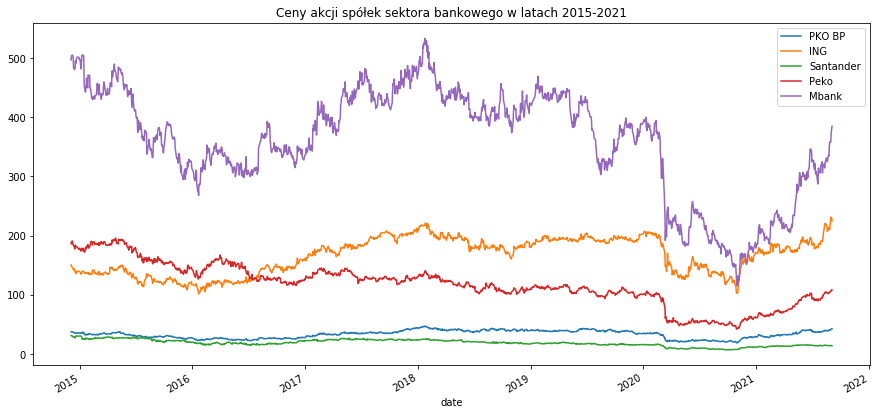

In [10]:
pkobp_s['close'].plot(label = 'PKO BP', figsize = (15,7))
ing_s['close'].plot(label = "ING")
santander_s['close'].plot(label = 'Santander')
pekao_s['close'].plot(label = 'Peko')
mbank_s['close'].plot(label = 'Mbank')
plt.title('Ceny akcji spółek sektora bankowego w latach 2015-2021')
plt.legend()
plt.savefig('ceny_akcji_razem.png')

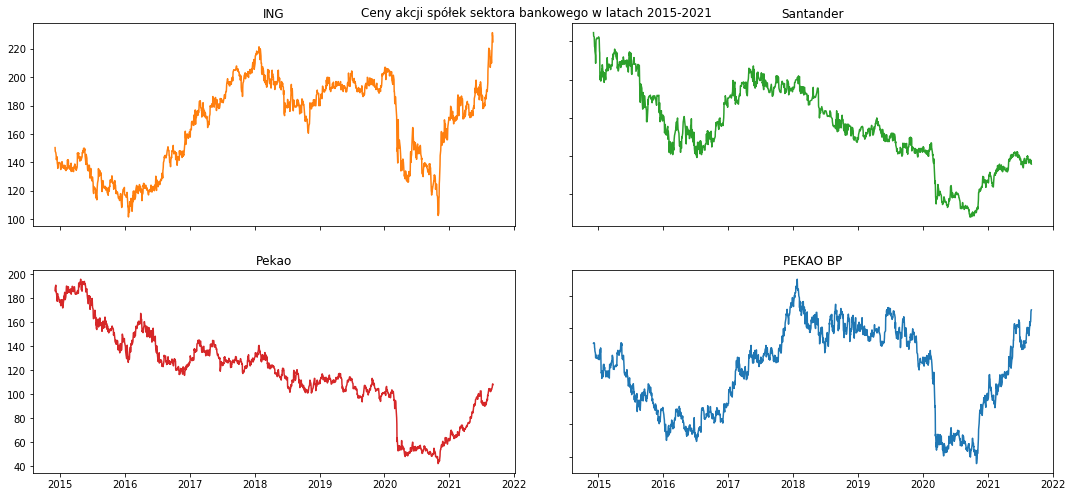

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,7))
fig.suptitle('Ceny akcji spółek sektora bankowego w latach 2015-2021')
ax1.plot(ing_s['close'], 'tab:orange')
plt.ylabel('close')
ax1.set_title('ING')
ax2.plot(santander_s['close'], 'tab:green')
plt.ylabel('close')
ax2.set_title('Santander')
ax3.plot(pekao_s['close'], 'tab:red')
ax3.set_title('Pekao')
plt.ylabel('close')
ax4.plot(pkobp_s['close'], 'tab:blue')
ax4.set_title('PEKAO BP')
plt.ylabel('close')
fig.tight_layout()

for ax in fig.get_axes():
    ax.label_outer()

Filtruj daty 2020

In [12]:
def filtruj_daty(df): 
    start_date = '2020-01-01'
    end_date = '2021-01-01'
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    return df.loc[mask]

In [13]:
pkobp_2020 = filtruj_daty(pkobp)
mbank_2020 = filtruj_daty(mbank)
pekao_2020 = filtruj_daty(pekao)
santander_2020 = filtruj_daty(santander)
ing_2020 = filtruj_daty(ing)

Funkcja tworząca wykres świecowy

In [14]:
def wykres_swiecowy_akcji(df,tytul_wykresu):

    fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

    fig.update_layout(
            title= tytul_wykresu,
            yaxis_title = "cena zamknięcia")

    return fig.show()

In [15]:
wykres_swiecowy_akcji(pkobp_2020, "Wykres świecowy akcji PKO BP")

In [16]:
wykres_swiecowy_akcji(mbank_2020, "Wykres świecowy akcji Mbanku")

In [17]:
wykres_swiecowy_akcji(pekao_2020, "Wykres świecowy akcji Pekao")

In [18]:
wykres_swiecowy_akcji(santander_2020, "Wykres świecowy akcji Santander")

In [19]:
wykres_swiecowy_akcji(ing_2020, "Wykres świecowy akcji ING Bank Śląski")

Statystyki opisowe i wykres dziennych stóp zwrotu

In [20]:
def kapitalizacja(df):
    
    
    df['date']=pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df[['open', 'high', 'low', 'close', 'vol']]
    df["kapitalizacja"] = df['close'] * df['vol']
    return df

In [21]:
pkobp_k = kapitalizacja(pkobp)
santander_k = kapitalizacja(santander)
ing_k = kapitalizacja(ing)
pekao_k = kapitalizacja(pekao)
mbank_k = kapitalizacja(mbank)

In [22]:
print('Pkobp kap', np.mean(pkobp_k['kapitalizacja']), 
      'Santander kap', np.mean(santander_k['kapitalizacja']),
      'ING', np.mean(ing_k['kapitalizacja']), 
      'PEKAO', np.mean(pekao_k['kapitalizacja']),
      'Mbank', np.mean(mbank_k['kapitalizacja']))


Pkobp kap 85667741.67102851 Santander kap 107469.17287928579 ING 2769264.026762433 PEKAO 53240900.75169301 Mbank 7328918.108507316


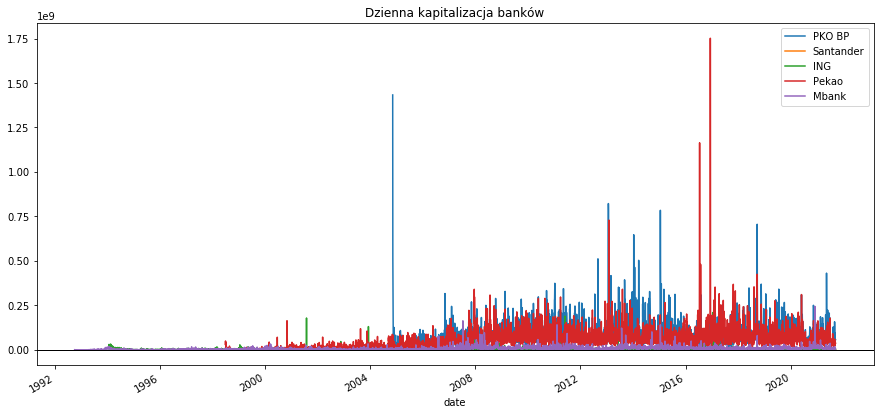

In [23]:



pkobp_k["kapitalizacja"].plot(label = 'PKO BP', figsize = (15,7))
santander_k["kapitalizacja"].plot(label = 'Santander')
ing_k["kapitalizacja"].plot(label = 'ING')
pekao_k["kapitalizacja"].plot(label = 'Pekao')
mbank_k["kapitalizacja"].plot(label = 'Mbank')
plt.axhline(0, color='black', lw=1)
plt.title(f"Dzienna kapitalizacja banków")
plt.legend()

In [24]:
def stopa_zwrotu(df, czestosc):
    
    """
    gdy czestosc to 1 funkcja zwraca dzienne stopy zwrotu dla wybranej spólki (df)
    gdy czestosc to 30 funkcja zwraca miesięczne stopy zwrotu zwrotu dla wybranej spólki (df)
    gdy czestosc to 365 funckja zwraca roczne stopy zwrotu zwrotu dla wybranej spólki (df)
    """
    
    df['date']=pd.to_datetime(df.date)
    df['stopa_zwrotu'] = df['close'].pct_change(periods=czestosc) 
    df = df.dropna()
    df = df.set_index('date')
    df = df['stopa_zwrotu']
    return df

In [25]:
pkobp_s = stopa_zwrotu(pkobp, 365)
santander_s = stopa_zwrotu(santander, 365)
ing_s = stopa_zwrotu(ing, 365)
pekao_s = stopa_zwrotu(pekao, 365)
mbank_s = stopa_zwrotu(mbank, 365)

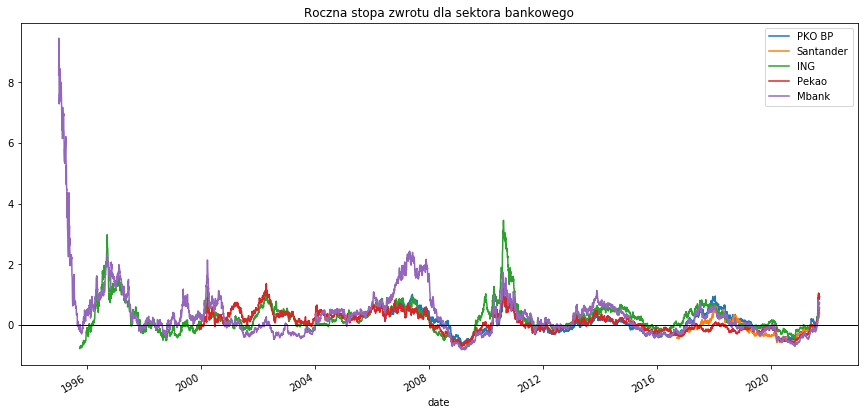

In [26]:
pkobp_s.plot(label = 'PKO BP', figsize = (15,7))
santander_s.plot(label = 'Santander')
ing_s.plot(label = 'ING')
pekao_s.plot(label = 'Pekao')
mbank_s.plot(label = 'Mbank')
plt.axhline(0, color='black', lw=1)
plt.title(f"Roczna stopa zwrotu dla sektora bankowego")
plt.legend()

In [27]:
def stopy_zwrotu_i_statystyki(df,nazwa):
    print(df.describe())
    
    df['date']=pd.to_datetime(df.date)
    df = df.set_index('date')
    
    df_vol = df['vol']
    df_vol.plot(figsize=(10,4))
    
    plt.axhline(0, color='black', lw=1)
    plt.title(f"Dzienna wielkość obrotu {nazwa}")
    
    df["kapitalizacja"] = df['close'] * df['vol']
    df_kap = df['kapitalizacja']
    df_kap.plot(figsize=(10,4))
    plt.axhline(0, color='black', lw=1)
    plt.title(f"Dzienna kapitalizacja {nazwa}")
    
    df['stopa_zwrotu'] = df['close'].pct_change()
    df = df.dropna()
    df2 = df['stopa_zwrotu']
    df2 = df2.reset_index()
    df2['date']=pd.to_datetime(df2.date)
    df2 = df2.set_index('date')
    df2.plot(figsize=(10,4))
    plt.axhline(0, color='black', lw=1)
    plt.title(f"Dzienna stopa zwrotu dla {nazwa}")
    df2.hist(bins = 100, label = nazwa, alpha = 0.5, figsize = (10,4))
    plt.title(f"Dystrybucja dziennej stopy zwrotu {nazwa}")
    
    df['miesięczna_stopa_zwrotu'] = df['close'].pct_change(periods=30)
    df = df.dropna()
    df3 = df['miesięczna_stopa_zwrotu']
    df3 = df3.reset_index()
    df3['date']=pd.to_datetime(df3.date)
    df3 = df3.set_index('date')
    df3.plot(figsize=(10,4))
    plt.axhline(0, color='black', lw=1)
    plt.title(f"Miesięczna stopa zwrotu dla {nazwa}")
    df3.hist(bins = 100, label = nazwa, alpha = 0.5, figsize = (10,4))
    plt.title(f"Dystrybucja miesięcznej stopy zwrotu {nazwa}")
    
    return plt.show()

In [28]:
pkobp.columns

Index(['Unnamed: 0', 'ticker', 'date', 'open', 'high', 'low', 'close', 'vol',
       'stopa_zwrotu'],
      dtype='object')

        Unnamed: 0         open         high          low        close  \
count  4215.000000  4215.000000  4215.000000  4215.000000  4215.000000   
mean   2108.000000    35.900083    36.384492    35.446686    35.930711   
std    1216.910021     7.515119     7.601205     7.472844     7.548853   
min       1.000000    18.510000    18.985000    18.210000    18.900000   
25%    1054.500000    30.600000    31.200000    30.115000    30.615000   
50%    2108.000000    36.080000    36.560000    35.660000    36.050000   
75%    3161.500000    40.605000    41.150000    40.175000    40.680000   
max    4215.000000    58.200000    59.250000    58.000000    59.000000   

                vol  stopa_zwrotu  
count  4.215000e+03   3850.000000  
mean   2.452206e+06      0.056321  
std    1.950601e+06      0.351668  
min    1.648120e+05     -0.636364  
25%    1.352642e+06     -0.217337  
50%    2.045300e+06      0.036011  
75%    3.021016e+06      0.275658  
max    5.848743e+07      1.159451  


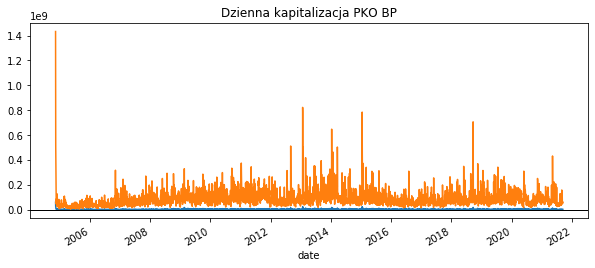

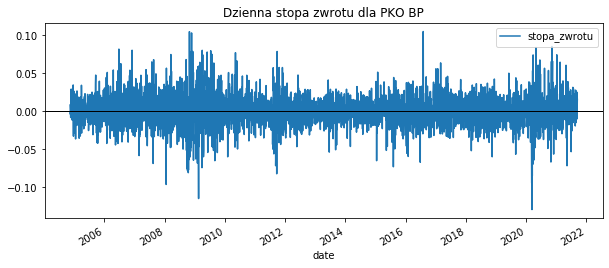

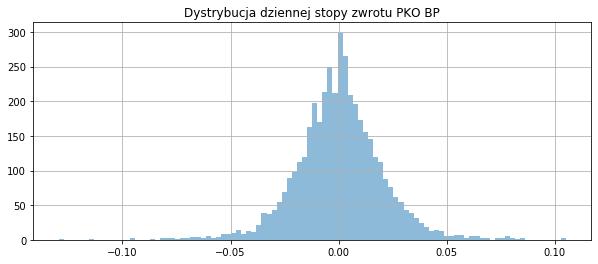

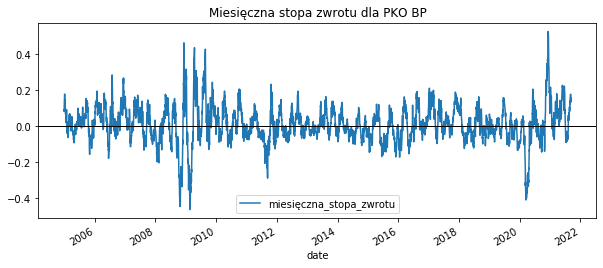

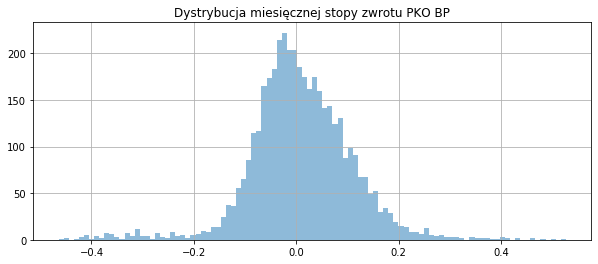

In [29]:
stopy_zwrotu_i_statystyki(pkobp,"PKO BP") #wszystkie spółki na raz XD

Funkcja porównująca średnie ruchome

In [30]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [31]:
def wykres_srednia_ruchoma(df, nazwa): 
    
    df['MA_14'] = df['close'].rolling(14).mean()
    df['MA_30'] = df['close'].rolling(30).mean()
    df['MA_60'] = df['close'].rolling(60).mean()
    df['MA_180'] = df['close'].rolling(180).mean()
    
    df['date']=pd.to_datetime(df.date)
    df = df.set_index('date')
    
    df['close'].plot(figsize = (15,7)) 
    df['MA_14'].plot()
    df['MA_30'].plot()
    df['MA_60'].plot()
    df['MA_180'].plot()

    plt.title(f'Wykres średniej ruchomej dla {nazwa}') 
    plt.xlabel('Data')
    plt.ylabel('Cena zamkniecia')
    plt.legend()
    
    return plt.show()

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

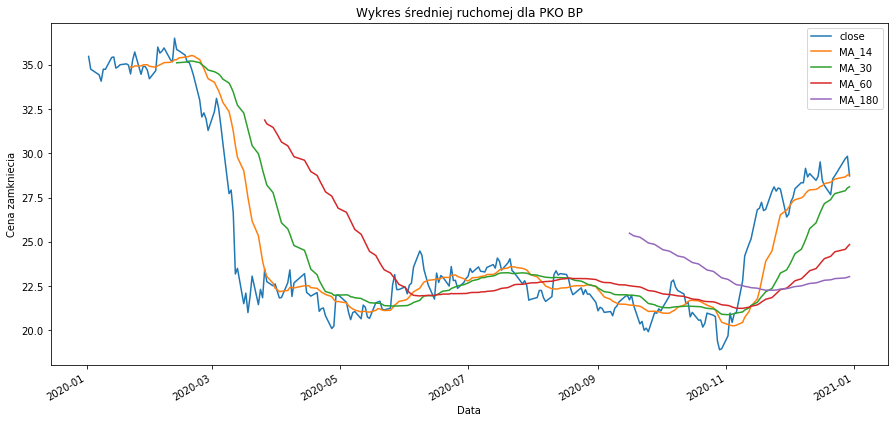

In [32]:
wykres_srednia_ruchoma(pkobp_2020, "PKO BP")

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

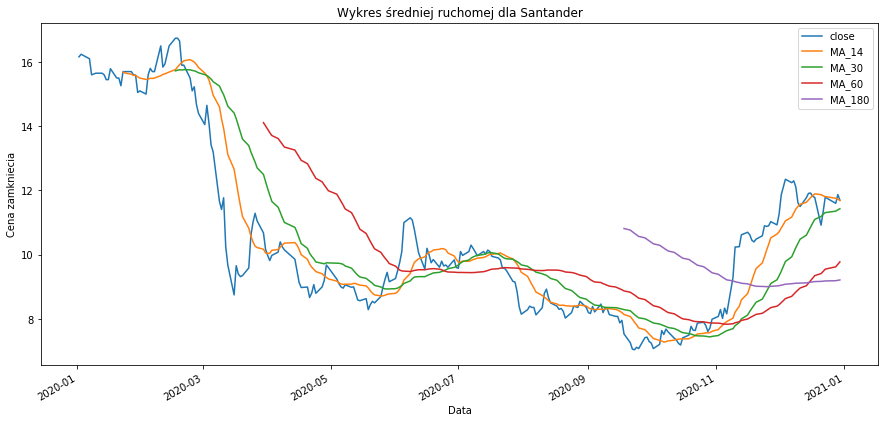

In [33]:
wykres_srednia_ruchoma(santander_2020, "Santander")

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

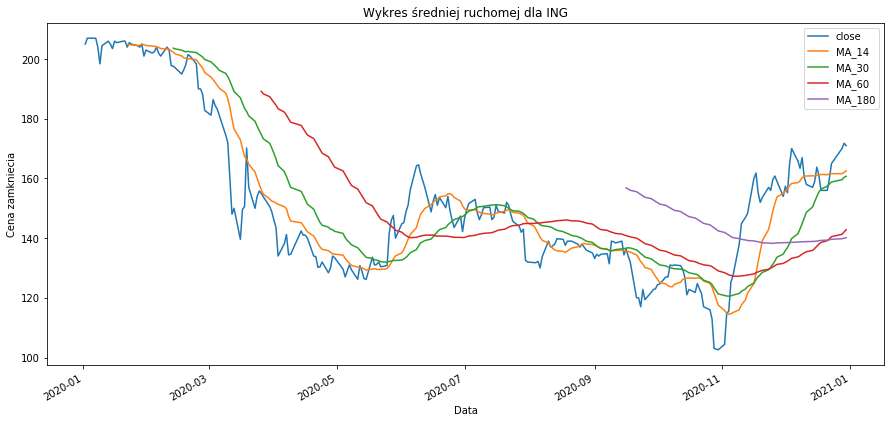

In [34]:
wykres_srednia_ruchoma(ing_2020, "ING")

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

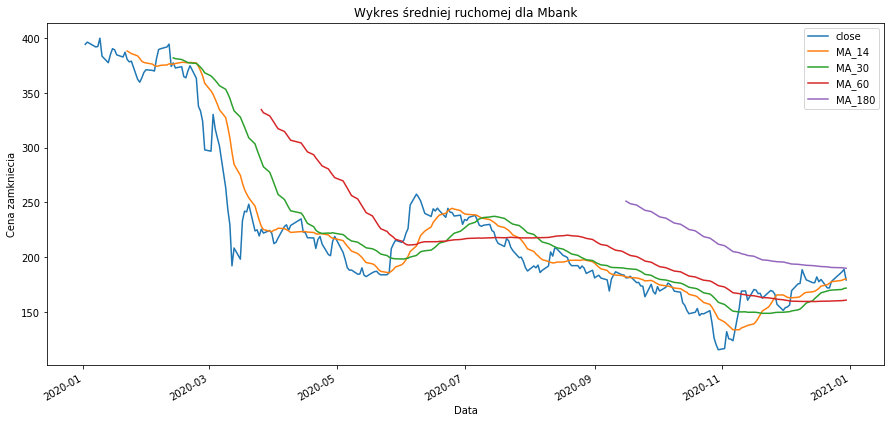

In [35]:
wykres_srednia_ruchoma(mbank_2020, "Mbank")

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

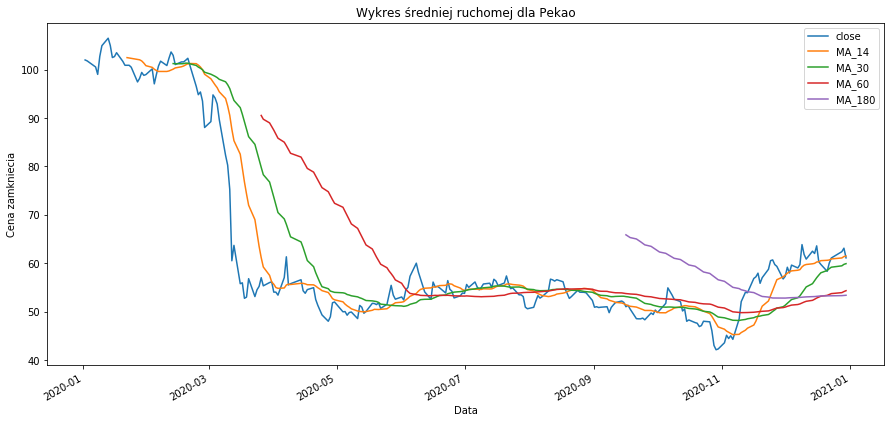

In [36]:
wykres_srednia_ruchoma(pekao_2020, "Pekao")

Podział na zbiór uczący i testowy

In [37]:
def zbior_uczacy(df):
    
    """
    Funkcja tworząca zbior uczący dla algorytmow. 
    zbiorem tesotywm jest cały rok 2021. 
    """
  
    df['date']=pd.to_datetime(df.date)
    df = df[['date', 'close']]
    start_date = '2020-01-01'
    end_date = '2021-01-01'
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    df = df.set_index('date')
    return df
    

In [38]:
def zbior_testowy(df):
    
    """
    Funkcja tworząca zbior testowy dla algorytmow. 
    zbiorem tesotywm są ceny zamknięcia za styczen 2021.
    """
    
    df['date']=pd.to_datetime(df.date)
    df = df[['date', 'close']]
    start_date = '2021-01-01'
    end_date = '2021-01-31'
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    df = df.set_index('date')
    
    return df

In [39]:
def bledy_prognozy(zbior_testowy, predykcje, nazwa):
    
    """
    Funkcja obliczajaca bledy prognozy na podstawie zbioru 
    testowego i predykcji, dla danej spolki. Zmienna nazwa to nazwa spółki. 
    """
    
    mae = mean_absolute_error(zbior_testowy, predykcje)
    print(f'MAE dla prognozy akcji {nazwa}: {mae}')
    mse = mean_squared_error(zbior_testowy, predykcje)
    print(f'MSE dla prognozy akcji {nazwa}: {mse}')
    rmse = np.sqrt(mse)
    print(f'RMSE dla pognozy akcji {nazwa}: {rmse}')
    MAPE = mape(zbior_testowy, predykcje)
    print(f'MAPE dla pognozy akcji {nazwa}: {MAPE}')
    
    df = pd.DataFrame({'mee':mae, 'mse': mse, 'rmse': rmse, 'MAPE': mape})
    
    return df

In [40]:
def Theil(f,y):
    
    """
    F to prognoza 
    Y to wartości rzeczywiste
    Funkcja oblicza wspolczynnik theila
    
    U^2=  (∑_(i=1)^n▒〖(Pi-Ai)〗^2 )/(∑_(i=1)^n▒〖Ai〗^2 )
    """
    
    
    y = y.reset_index(drop=True).values.flatten()
    f = f.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i':f, 'y_i': y})
    df['(f_i - y_i)^2'] = np.square(df['f_i'] - df['y_i'])
    df['y_i^2'] = np.square(df['y_i'])
    wsp_Theila = ((np.sum(df['(f_i - y_i)^2']))/np.sum(df['y_i^2']))
    
    print (f'Współczynnik theila wynosi: {wsp_Theila}')

    
    return wsp_Theila


In [41]:
def Theil_obciązalnosc_prognozy(f,y):
    
    """
    F to prognoza 
    Y to wartości rzeczywiste
    Funkcja oblicza wspolczynnik obciązonosci prognozy theila
    
      〖(P ̅-A ̅)〗^2/(1/n ∑_(i=1)^n▒〖(Pi-Ai)〗^2 )
    """
    
    y = y.reset_index(drop=True).values.flatten()
    f = f.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i':f, 'y_i': y})
    df['(f_i - y_i)^2'] = np.square(df['f_i'] - df['y_i'])
    df['(sr_f_i - sr_y_i)^2'] = np.square(np.mean(df['f_i']) - np.mean(df['y_i']))
    
    wsp_Theila_o = df['(sr_f_i - sr_y_i)^2']/np.sum(df['(f_i - y_i)^2']/len(df['f_i']))
    
    print (f'Współczynnik obciazonosci prognozy wynosi: {wsp_Theila_o}')

    
    return wsp_Theila_o

In [42]:
def Theil_elastycznosc_prognozy(f,y):
    
    """
    F to prognoza 
    Y to wartości rzeczywiste
    Funkcja oblicza wspolczynnik elastycznosci prognozy theila
    
      〖(P ̅-A ̅)〗^2/(1/n ∑_(i=1)^n▒〖(Pi-Ai)〗^2 )
    """
    
    y = y.reset_index(drop=True).values.flatten()
    f = f.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i':f, 'y_i': y})
    df['(f_i - y_i)^2'] = np.square(df['f_i'] - df['y_i'])
    df['(std_f_i - std_y_i)^2'] = np.square((np.std(df['f_i'])) - np.std(df['y_i']))
    
    wsp_Theila_e = np.sum(df['(std_f_i - std_y_i)^2'])/(np.sum(df['(f_i - y_i)^2'])/len(df['(f_i - y_i)^2']))
    
    print (f'Współczynnik elastycznoscici prognozy wynosi: {wsp_Theila_e}')

    
    return wsp_Theila_e

In [43]:
def wspolczynniki_Theila(f,y):
    
    glowny = Theil(f,y)
    obciazonosci = Theil_obciązalnosc_prognozy(f,y)
    elastycznosci = Theil_elastycznosc_prognozy(f,y)
    
    l = [glowny, obciazonosci, elastycznosci]
    
    return l

Forecastowanie średnie ruchome

In [44]:
def prognoza_srednia_ruchoma(df, nazwa):
    

    df_train = zbior_uczacy(df)
    df_test = zbior_testowy(df)

  # Trenowanie modelu

    model = ARMA(df_train['close'], order=(0, 1))
    results = model.fit()
    predictions = results.forecast(steps=len(df_test))
    predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])
    
    # bledy expost 
    
    mae = mean_absolute_error(df_test['close'], predictions_df)
    print(f'MAE dla prognozy akcji {nazwa}: {mae}')
    mse = mean_squared_error(df_test['close'], predictions_df)
    print(f'MSE dla prognozy akcji {nazwa}: {mse}')
    rmse = np.sqrt(mse)
    print(f'RMSE dla pognozy akcji {nazwa}: {rmse}')
    MAPE = mape(df_test['close'], predictions_df)
    print(f'MAPE dla pognozy akcji {nazwa}: {MAPE}')
    
    wspolczynniki_Theila(df_test['close'], predictions_df)
    
  # Wykres
    
    plt.figure(figsize = (15,10))
    plt.title(f"Model średnich ruchomych dla {nazwa}")
    plt.plot(df_train['close'], label = 'dane treningowe')
    plt.plot(df_test['close'], color = 'blue', label = 'dane testowe')
    plt.plot(predictions_df, color = 'green', label = 'pognoza')
    plt.legend()
    
    return plt.show()

# RMSE = 10, MAPE = 0.02 In a nutshell — on an average month, the predictions are off by 10 passenger units (thousands), or around 2.5%. That’s all you should know.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAE dla prognozy akcji PKO BP: 5.189119210411321
MSE dla prognozy akcji PKO BP: 29.06143929208899
RMSE dla pognozy akcji PKO BP: 5.390866284011225
MAPE dla pognozy akcji PKO BP: 16.903840093173994
Współczynnik theila wynosi: 0.04555528378277114
Współczynnik obciazonosci prognozy wynosi: 0     0.926553
1     0.926553
2     0.926553
3     0.926553
4     0.926553
5     0.926553
6     0.926553
7     0.926553
8     0.926553
9     0.926553
10    0.926553
11    0.926553
12    0.926553
13    0.926553
14    0.926553
15    0.926553
16    0.926553
17    0.926553
18    0.926553
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 0.41328017310617


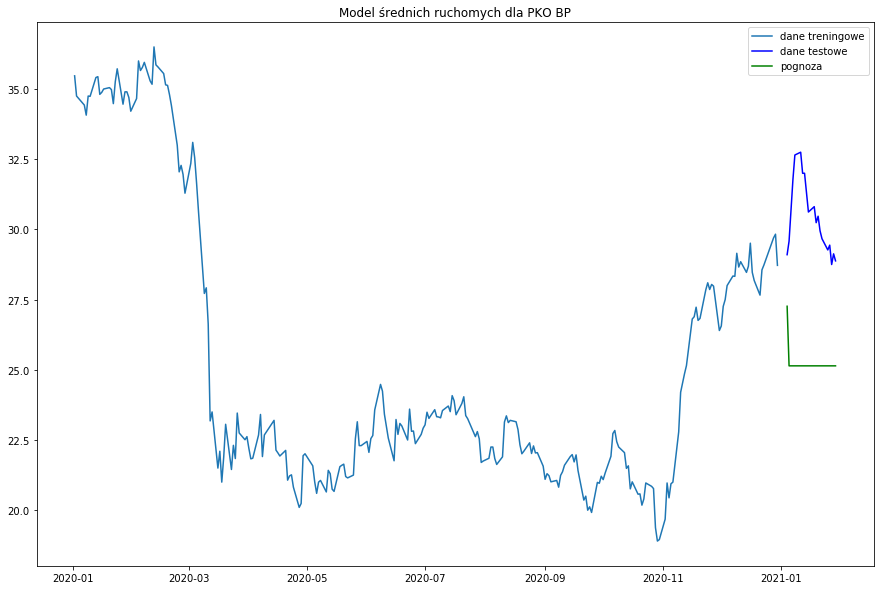

In [45]:
prognoza_srednia_ruchoma(pkobp, "PKO BP")

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAE dla prognozy akcji ING: 20.5822094248798
MSE dla prognozy akcji ING: 437.8234209114324
RMSE dla pognozy akcji ING: 20.92423047357853
MAPE dla pognozy akcji ING: 11.866975215371765
Współczynnik theila wynosi: 0.018833417924531748
Współczynnik obciazonosci prognozy wynosi: 0     0.967576
1     0.967576
2     0.967576
3     0.967576
4     0.967576
5     0.967576
6     0.967576
7     0.967576
8     0.967576
9     0.967576
10    0.967576
11    0.967576
12    0.967576
13    0.967576
14    0.967576
15    0.967576
16    0.967576
17    0.967576
18    0.967576
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 0.07191040770098313


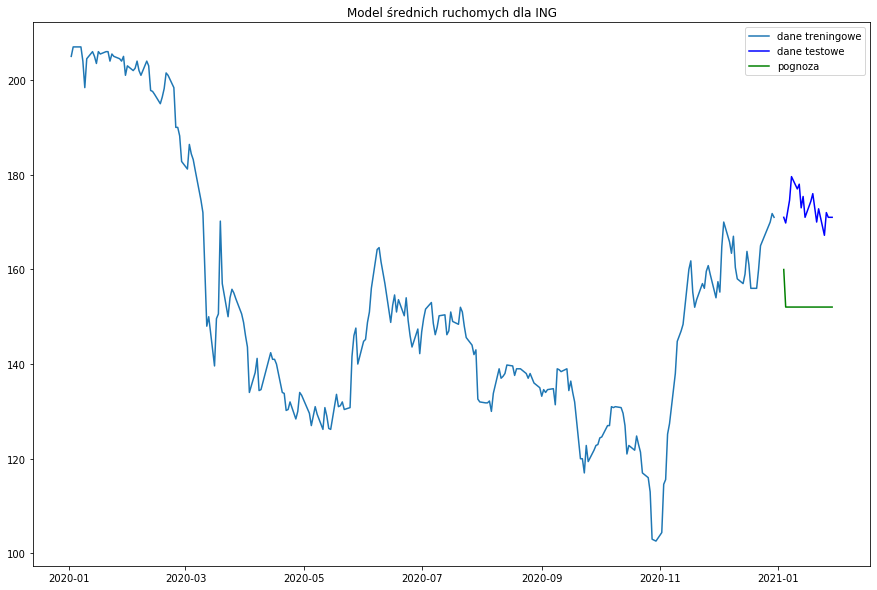

In [46]:
prognoza_srednia_ruchoma(ing, "ING")

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAE dla prognozy akcji Santander: 1.5557618474917398
MSE dla prognozy akcji Santander: 2.867642165185161
RMSE dla pognozy akcji Santander: 1.6934113986817148
MAPE dla pognozy akcji Santander: 12.72044705921024
Współczynnik theila wynosi: 0.02612457907435417
Współczynnik obciazonosci prognozy wynosi: 0     0.844037
1     0.844037
2     0.844037
3     0.844037
4     0.844037
5     0.844037
6     0.844037
7     0.844037
8     0.844037
9     0.844037
10    0.844037
11    0.844037
12    0.844037
13    0.844037
14    0.844037
15    0.844037
16    0.844037
17    0.844037
18    0.844037
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 1.2814140990155076


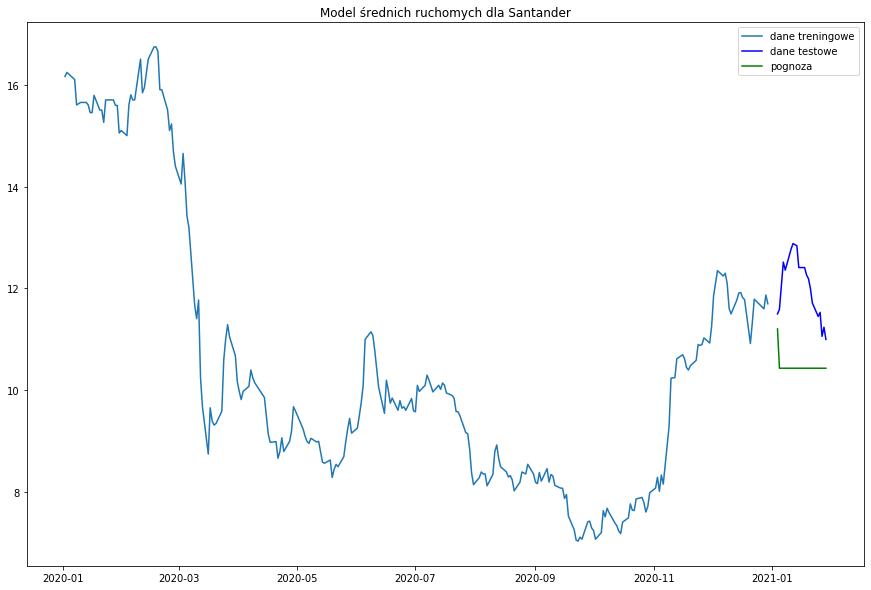

In [47]:
prognoza_srednia_ruchoma(santander, "Santander")

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAE dla prognozy akcji Pekao: 3.6681274465242644
MSE dla prognozy akcji Pekao: 18.046880022324274
RMSE dla pognozy akcji Pekao: 4.248161958108974
MAPE dla pognozy akcji Pekao: 5.20196329703396
Współczynnik theila wynosi: 0.004616676195241719
Współczynnik obciazonosci prognozy wynosi: 0     0.6209
1     0.6209
2     0.6209
3     0.6209
4     0.6209
5     0.6209
6     0.6209
7     0.6209
8     0.6209
9     0.6209
10    0.6209
11    0.6209
12    0.6209
13    0.6209
14    0.6209
15    0.6209
16    0.6209
17    0.6209
18    0.6209
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 4.059521419111174


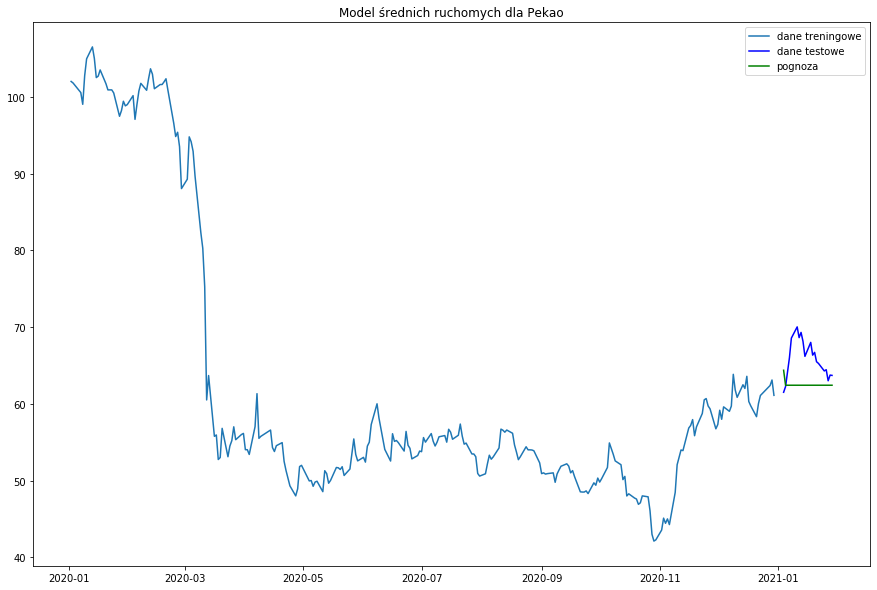

In [48]:
prognoza_srednia_ruchoma(pekao, "Pekao")

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAE dla prognozy akcji Mbank: 21.654475658147355
MSE dla prognozy akcji Mbank: 533.711314992604
RMSE dla pognozy akcji Mbank: 23.102192861124763
MAPE dla pognozy akcji Mbank: 11.010869404009133
Współczynnik theila wynosi: 0.010528169815653226
Współczynnik obciazonosci prognozy wynosi: 0     0.878595
1     0.878595
2     0.878595
3     0.878595
4     0.878595
5     0.878595
6     0.878595
7     0.878595
8     0.878595
9     0.878595
10    0.878595
11    0.878595
12    0.878595
13    0.878595
14    0.878595
15    0.878595
16    0.878595
17    0.878595
18    0.878595
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 0.6172697774214106


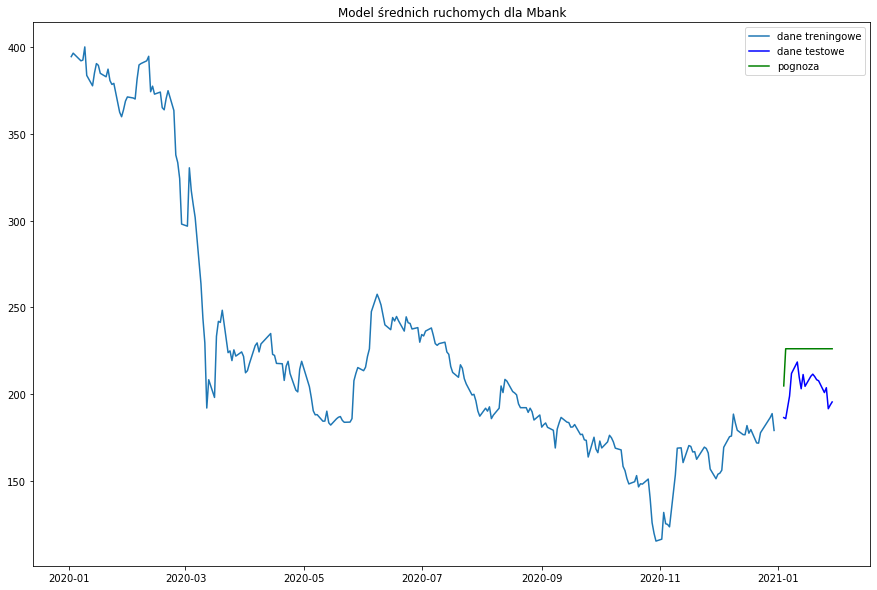

In [49]:
prognoza_srednia_ruchoma(mbank, "Mbank")

EWMA 

In [50]:
def EWMA_wykresy(df, nazwa):
    
    df['EWMA_14'] = df['close'].ewm(span=14, adjust=False).mean()
    df['EWMA_30'] = df['close'].ewm(span=30, adjust=False).mean()
    df['EWMA_60'] = df['close'].ewm(span=60, adjust=False).mean()
        
    df['date']=pd.to_datetime(df.date)
    df = df.set_index('date')
    
    plt.figure(figsize=(15,10))
    plt.title(f'Wykres EWMA dla {nazwa}', size=20)
    plt.plot(df['close'], label='Cena zamkniecial')
    plt.plot(df['EWMA_14'], color='gray', label='EWMA 14')
    plt.plot(df['EWMA_30'], color='orange', label='EWMA 30')
    plt.plot(df['EWMA_60'], color='red', label='EWMA 60')
    plt.legend()
    
    return plt.show()

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

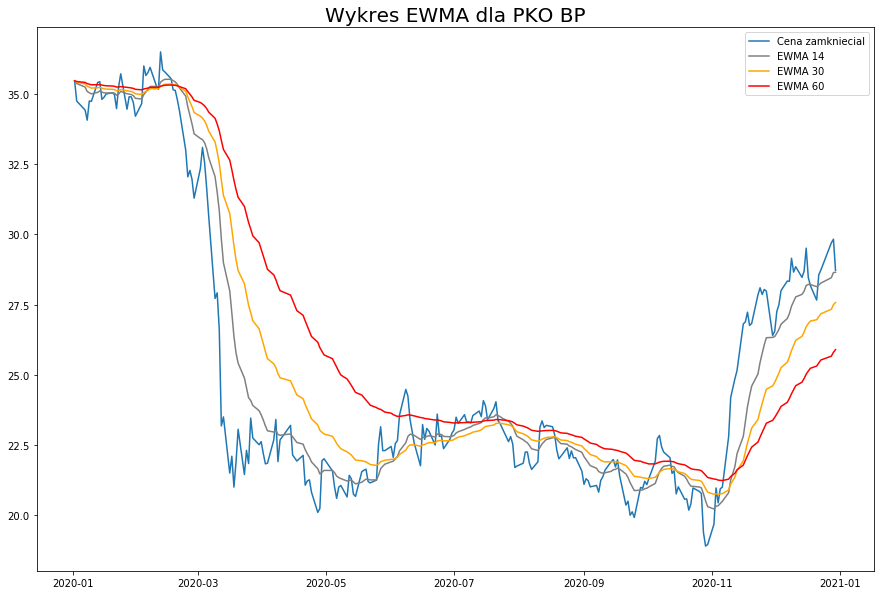

In [51]:
EWMA_wykresy(pkobp_2020, "PKO BP")

In [52]:
def EWMA_i_MA(df, nazwa):
    
    df['MA_14'] = df['close'].rolling(14).mean()
    df['EWMA_14'] = df['close'].ewm(span=14, adjust=False).mean()
    df['date']=pd.to_datetime(df.date)
    df = df.set_index('date')
    plt.figure(figsize=(15,10))
    plt.title(f'Porównanie wykresów EWMA i MA dla {nazwa}', size=20)
    plt.plot(df['EWMA_14'], color='gray', label='EWMA 14')
    df['close'].plot(label = 'cena zamkniecia')
    df['MA_14'].plot(label='MA 14')
    plt.legend()
    
    return plt.show()

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

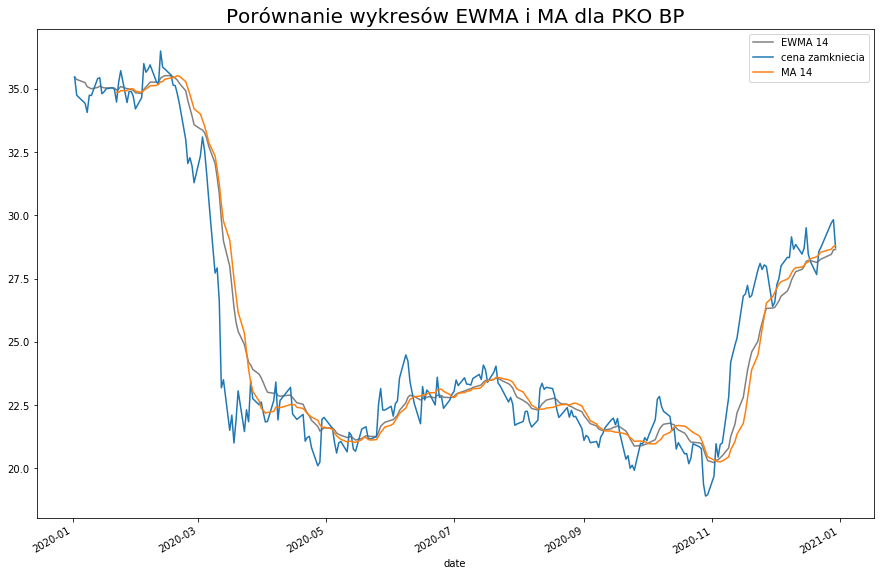

In [53]:
EWMA_i_MA(pkobp_2020, "PKO BP")

In [54]:
santander

Unnamed: 0     ticker       date    open   high    low   close     vol  \
0              1  SANTANDER 2014-12-03  30.570  31.80  30.57  31.050  199964   
1              2  SANTANDER 2014-12-04  31.280  31.30  30.97  31.160   22685   
2              3  SANTANDER 2014-12-05  31.250  31.25  30.30  30.680    3567   
3              4  SANTANDER 2014-12-08  30.600  31.00  30.60  30.600    2382   
4              5  SANTANDER 2014-12-09  30.700  30.78  29.65  29.730    5864   
...          ...        ...        ...     ...    ...    ...     ...     ...   
1395        1396  SANTANDER 2021-09-07  14.142  14.18  14.06  14.130    3766   
1396        1397  SANTANDER 2021-09-08  14.130  14.13  13.78  13.932   15576   
1397        1398  SANTANDER 2021-09-09  13.930  13.93  13.78  13.850    4541   
1398        1399  SANTANDER 2021-09-10  14.090  14.25  13.85  13.850   11047   
1399        1400  SANTANDER 2021-09-13  14.200  14.20  13.86  14.152    1548   

      stopa_zwrotu  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
1395      0.283612  
1396      0.234012  
1397      0.253394  
1398      0.296816  
1399      0.391544  

[1400 rows x 9 columns]

Exponential moving average - EWMA

In [55]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def EWMA_prognoza(df, nazwa):

    span = 12 
    alpha = 2 / (span + 1)
   
  # podział na zbiór uczący i testow
    df_train = zbior_uczacy(df)
    df_test = zbior_testowy(df)

  # Trenowanie modelu
    model = SimpleExpSmoothing(df_train['close'])
    results = model.fit(smoothing_level=alpha, optimized=False)
    predictions = results.forecast(steps=len(df_test))  
    predictions = predictions.to_frame().set_index(df_test.index)
    
    # bledy expost 
    
    mae = mean_absolute_error(df_test['close'], predictions)
    print(f'MAE dla prognozy akcji {nazwa}: {mae}')
    mse = mean_squared_error(df_test['close'], predictions)
    print(f'MSE dla prognozy akcji {nazwa}: {mse}')
    rmse = np.sqrt(mse)
    print(f'RMSE dla pognozy akcji {nazwa}: {rmse}')
    MAPE = mape(df_test['close'], predictions)
    print(f'MAPE dla pognozy akcji {nazwa}: {MAPE}')
    
    wspolczynniki_Theila(df_test['close'], predictions)
  # Wykres


    plt.figure(figsize = (15,10))
    plt.title(f"Model EWMA dla {nazwa}")
    plt.plot(df_train['close'], label = 'dane treningowe')
    plt.plot(df_test['close'], color = 'blue', label = 'dane testowe')
    plt.plot(predictions, color = 'green', label = 'pognozy')
    plt.legend()
    
    return plt.show()

MAE dla prognozy akcji ING: 8.60705957212126
MSE dla prognozy akcji ING: 83.43549109854284
RMSE dla pognozy akcji ING: 9.134302989201904
MAPE dla pognozy akcji ING: 4.94445849076159
Współczynnik theila wynosi: 0.003085759394608959
Współczynnik obciazonosci prognozy wynosi: 0     0.887889
1     0.887889
2     0.887889
3     0.887889
4     0.887889
5     0.887889
6     0.887889
7     0.887889
8     0.887889
9     0.887889
10    0.887889
11    0.887889
12    0.887889
13    0.887889
14    0.887889
15    0.887889
16    0.887889
17    0.887889
18    0.887889
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 2.1301045088781296


C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



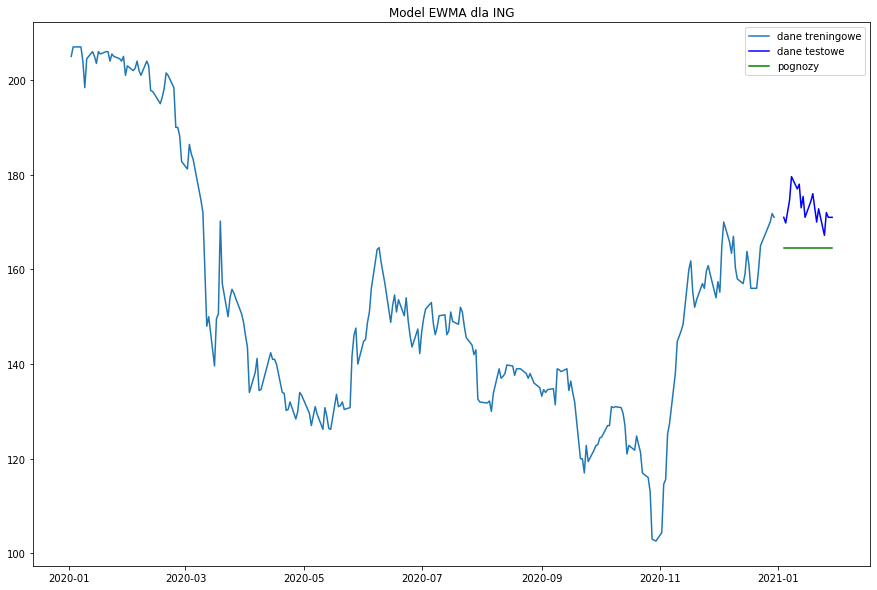

In [56]:
EWMA_prognoza(ing, "ING")

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAE dla prognozy akcji PKO BP: 1.6901632905582646
MSE dla prognozy akcji PKO BP: 4.466033169246271
RMSE dla pognozy akcji PKO BP: 2.1132991196814213
MAPE dla pognozy akcji PKO BP: 5.390400969228071
Współczynnik theila wynosi: 0.005402324605914889
Współczynnik obciazonosci prognozy wynosi: 0     0.639467
1     0.639467
2     0.639467
3     0.639467
4     0.639467
5     0.639467
6     0.639467
7     0.639467
8     0.639467
9     0.639467
10    0.639467
11    0.639467
12    0.639467
13    0.639467
14    0.639467
15    0.639467
16    0.639467
17    0.639467
18    0.639467
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 6.850131790363898


C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



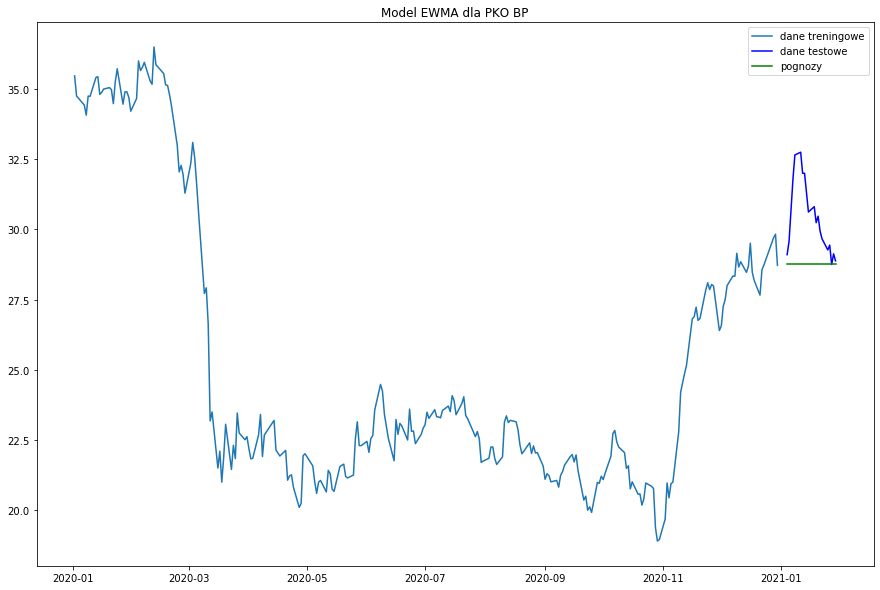

In [57]:
EWMA_prognoza(pkobp, "PKO BP")

MAE dla prognozy akcji Santander: 0.6102339728479651
MSE dla prognozy akcji Santander: 0.5193776417595547
RMSE dla pognozy akcji Santander: 0.7206785981001202
MAPE dla pognozy akcji Santander: 4.963802108518937
Współczynnik theila wynosi: 0.00382629454154255
Współczynnik obciazonosci prognozy wynosi: 0     0.278988
1     0.278988
2     0.278988
3     0.278988
4     0.278988
5     0.278988
6     0.278988
7     0.278988
8     0.278988
9     0.278988
10    0.278988
11    0.278988
12    0.278988
13    0.278988
14    0.278988
15    0.278988
16    0.278988
17    0.278988
18    0.278988
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 13.699227400216936


C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



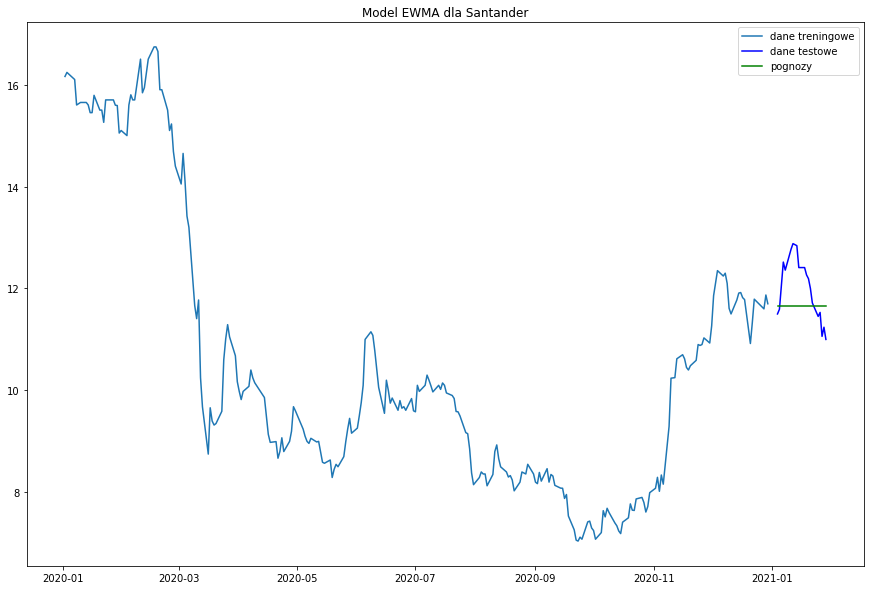

In [58]:
EWMA_prognoza(santander, "Santander")

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MAE dla prognozy akcji Pekao: 4.8039412513856785
MSE dla prognozy akcji Pekao: 28.833233264216513
RMSE dla pognozy akcji Pekao: 5.369658579855567
MAPE dla pognozy akcji Pekao: 7.169806912085989
Współczynnik theila wynosi: 0.007732430442084126
Współczynnik obciazonosci prognozy wynosi: 0     0.800391
1     0.800391
2     0.800391
3     0.800391
4     0.800391
5     0.800391
6     0.800391
7     0.800391
8     0.800391
9     0.800391
10    0.800391
11    0.800391
12    0.800391
13    0.800391
14    0.800391
15    0.800391
16    0.800391
17    0.800391
18    0.800391
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 3.792576837620495


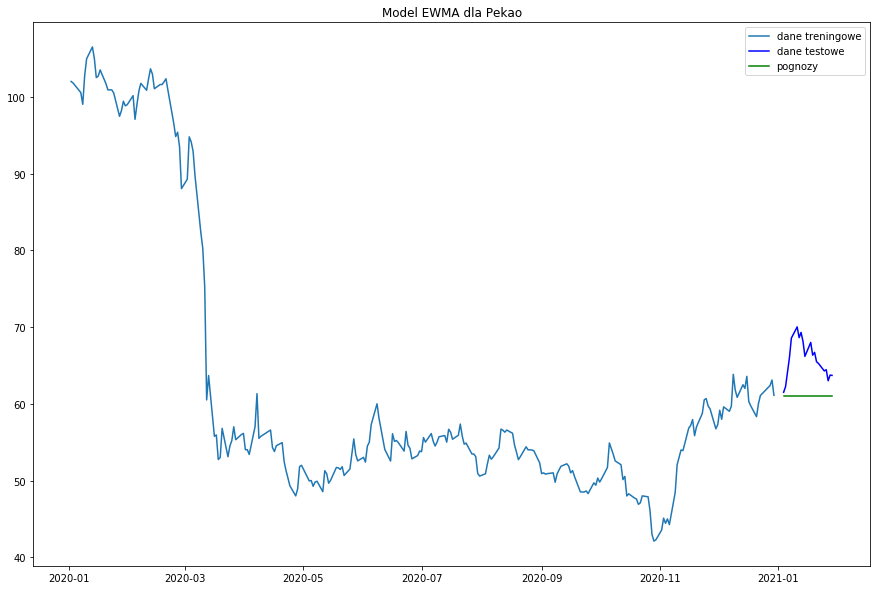

In [59]:
EWMA_prognoza(pekao, "Pekao")

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MAE dla prognozy akcji Mbank: 24.59723382651535
MSE dla prognozy akcji Mbank: 684.9400892015896
RMSE dla pognozy akcji Mbank: 26.171360094607035
MAPE dla pognozy akcji Mbank: 11.915883043200797
Współczynnik theila wynosi: 0.021412828732132776
Współczynnik obciazonosci prognozy wynosi: 0     0.883324
1     0.883324
2     0.883324
3     0.883324
4     0.883324
5     0.883324
6     0.883324
7     0.883324
8     0.883324
9     0.883324
10    0.883324
11    0.883324
12    0.883324
13    0.883324
14    0.883324
15    0.883324
16    0.883324
17    0.883324
18    0.883324
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 2.216846980282594


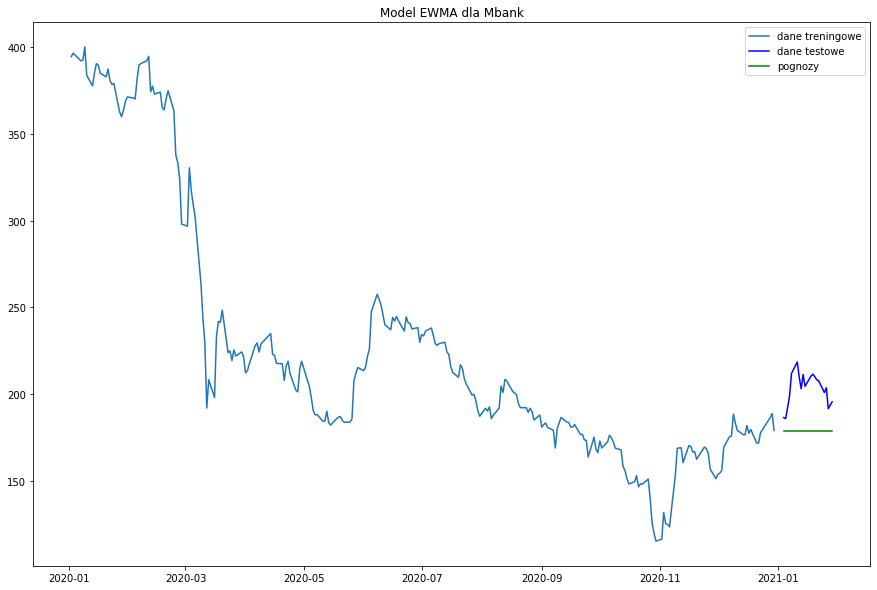

In [60]:
EWMA_prognoza(mbank, "Mbank")

Autoarima

In [61]:
def auto_arima_model(df, nazwa):
    
  # podział na zbiór uczący i testowy
    df_train = zbior_uczacy(df)
    df_test = zbior_testowy(df)

  # Trenowanie modelu


    arima_model =  auto_arima(df_train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=False, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True)



    print(arima_model.summary())


    predictions = pd.DataFrame(arima_model.predict(n_periods = len(df_test)),index=df_test.index)
 
    from sklearn.metrics import r2_score
    df_test['prognoza'] = predictions
    
    print(predictions)
    
    r2 = r2_score(df_test['close'], df_test['prognoza'])
    print(f'R^2 dla prognozy akcji {nazwa}: {r2}')

    
  # Błędy prognozy
    mae = mean_absolute_error(df_test['close'], df_test['prognoza'])
    print(f'MAE dla prognozy akcji {nazwa}: {mae}')
    mse = mean_squared_error(df_test['close'], df_test['prognoza'])
    print(f'MSE dla prognozy akcji {nazwa}: {mse}')
    rmse = np.sqrt(mse)
    print(f'RMSE dla pognozy akcji {nazwa}: {rmse}')
    MAPE = mape(df_test['close'], df_test['prognoza'])
    print(f'MAPE dla pognozy akcji {nazwa}: {MAPE}')
    
    wspolczynniki_Theila(df_test['close'], df_test['prognoza'])  
    
  # Wykres
    
    plt.figure(figsize = (15,10))
    plt.title(f"Model ARIMA dla {nazwa}")
    plt.plot(df_train['close'], label = 'dane treningowe')
    plt.plot(df_test['close'], color = 'blue', label = 'dane testowe')
    plt.plot(predictions, color = 'green', label = 'pognozy')
    plt.legend()
    
    return plt.show()

C:\Users\patry\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:60: UserWarning:

m (12) set for non-seasonal fit. Setting to 0

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=525.645, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=527.618, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=527.622, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=524.033, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=527.270, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.273 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -261.017
Date:                Wed, 22 Sep 2021   AIC                            524.033
Time:                        01:00:35   BIC                            527.559
Sample:                             0   HQIC                           525.452
                                - 252                                         
Co

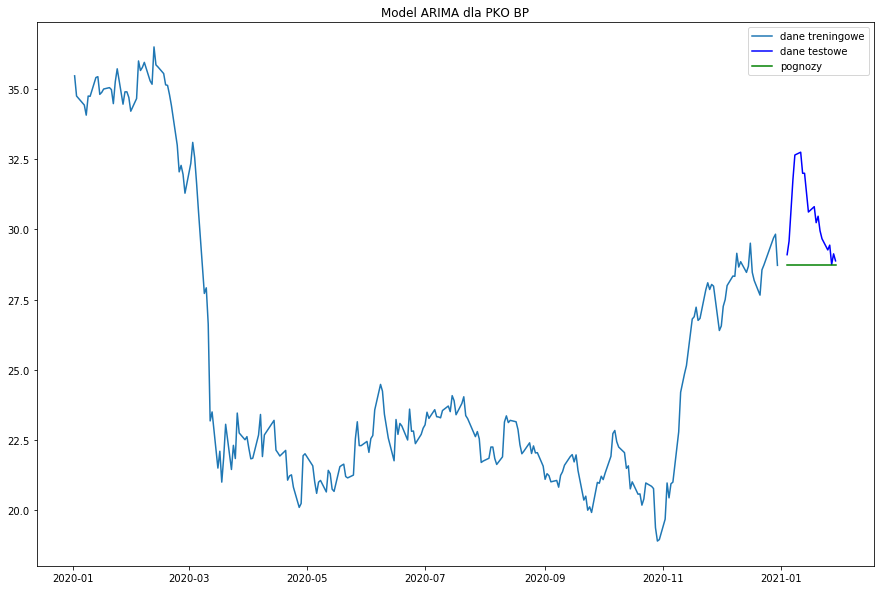

In [62]:
auto_arima_model(pkobp, "PKO BP")

C:\Users\patry\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:60: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1434.117, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1435.848, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1435.874, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1432.381, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1437.457, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.172 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -715.191
Date:                Wed, 22 Sep 2021   AIC                           1432.381
Time:                        01:00:35   BIC                           1435.907
Sample:                             0   HQIC                          1433.800
                                - 252                                       

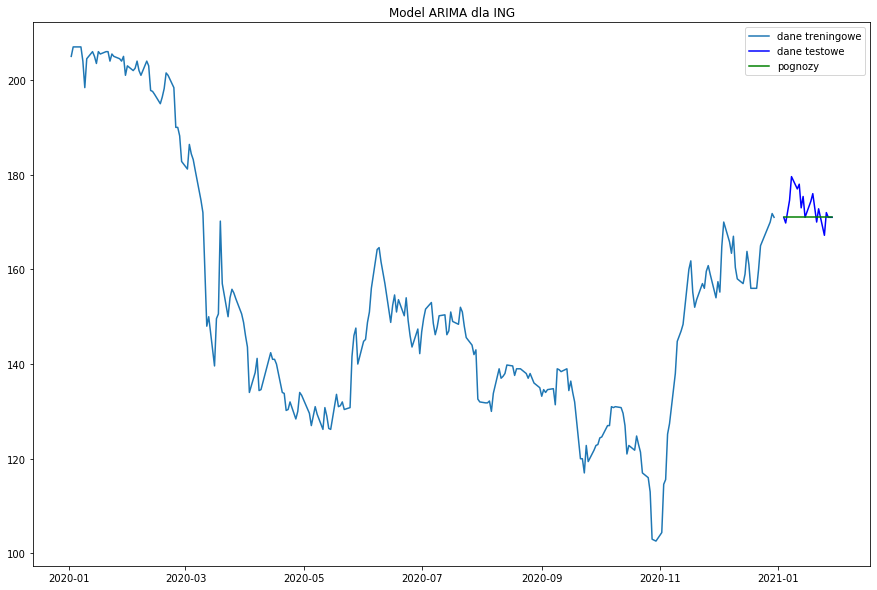

In [63]:
auto_arima_model(ing, "ING")

C:\Users\patry\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:60: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=157.065, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154.787, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=155.398, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=155.802, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=155.024, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=154.509, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=156.459, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=156.455, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=155.592, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=158.415, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=152.914, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=154.004, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=153.356, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=154.876, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=154.8

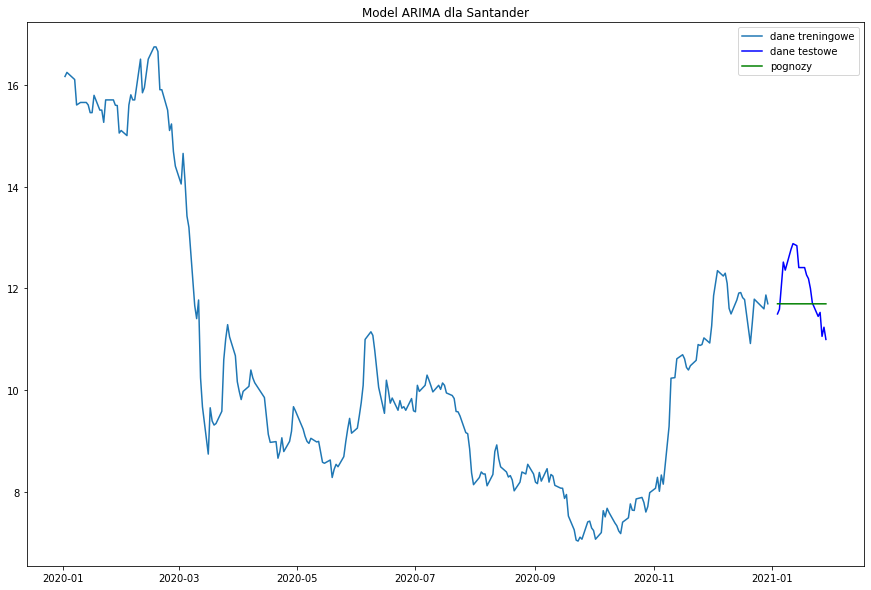

In [64]:
auto_arima_model(santander, "Santander")

C:\Users\patry\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:60: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1788.757, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1788.265, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1788.523, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1789.317, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1789.529, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1789.859, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1791.528, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1788.358, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.401 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -891.132
Date:                Wed, 22 Sep 2021   AIC                           1788.265
Time:                        01:00:3

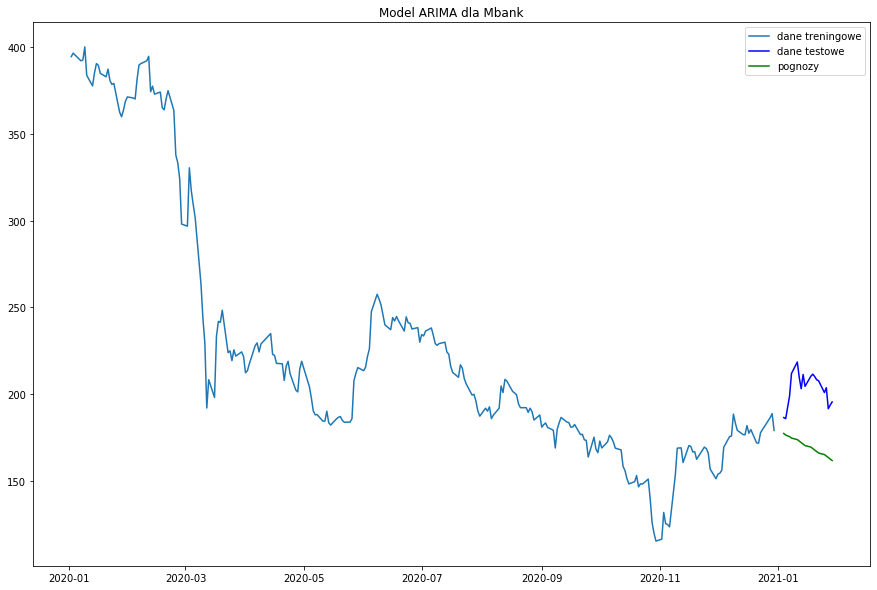

In [65]:
auto_arima_model(mbank, "Mbank")

C:\Users\patry\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:60: UserWarning:

m (12) set for non-seasonal fit. Setting to 0

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1066.579, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1067.779, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1067.898, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1066.224, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1065.882, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1066.985, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1066.851, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1068.114, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1067.665, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1068.492, Time=0.18 sec


C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1064.630, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1067.401, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1067.250, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1065.799, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1065.688, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1067.451, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1066.899, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1067.224, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.160 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -529.315
Date:                Wed, 22 Sep 2021   AIC                           1064.630
Time:                        01:00:39   BIC                           1075.206


C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.




Współczynnik obciazonosci prognozy wynosi: 0     0.805216
1     0.805216
2     0.805216
3     0.805216
4     0.805216
5     0.805216
6     0.805216
7     0.805216
8     0.805216
9     0.805216
10    0.805216
11    0.805216
12    0.805216
13    0.805216
14    0.805216
15    0.805216
16    0.805216
17    0.805216
18    0.805216
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 3.5839223864807943


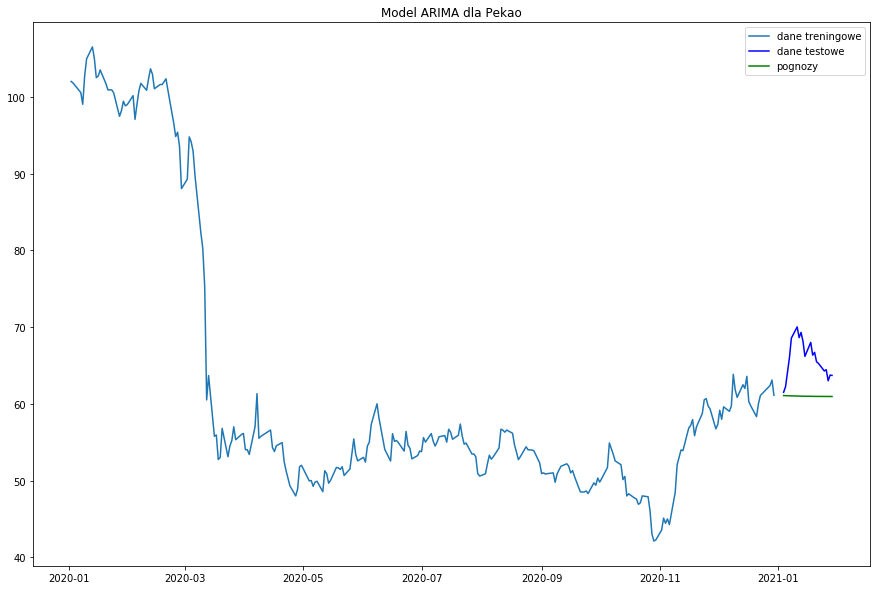

In [66]:

auto_arima_model(pekao, "Pekao")

Dane covid

In [67]:
covid = pd.read_csv('dane_covid.csv', sep = ';')


In [68]:
covid_test = pd.read_csv('X_test.csv', sep = ';')

In [69]:
covid_test.columns

Index(['date', 'covid_cum', 'covid_day', 'inflacja', 'Wibor_d'], dtype='object')

In [70]:
covid = covid[["date", "covid_cum", "covid_day", "inflacja", "Wibor_d"]]
covid_test = covid_test[["date", "covid_cum", "covid_day", "inflacja", "Wibor_d"]]
covid.head()

date  covid_cum  covid_day  inflacja  Wibor_d
0  2020-03-04          1          1     100.2     1.54
1  2020-03-05          1          0     100.2     1.54
2  2020-03-06          5          4     100.2     1.54
3  2020-03-07          5          0     100.2     1.54
4  2020-03-08         11          6     100.2     1.54

In [71]:
covid["date"] = pd.to_datetime(covid["date"])
covid_test["date"] = pd.to_datetime(covid_test["date"])
covid.head()

date  covid_cum  covid_day  inflacja  Wibor_d
0 2020-03-04          1          1     100.2     1.54
1 2020-03-05          1          0     100.2     1.54
2 2020-03-06          5          4     100.2     1.54
3 2020-03-07          5          0     100.2     1.54
4 2020-03-08         11          6     100.2     1.54

In [72]:
covid['inflacja'] = covid["inflacja"].astype(float)
covid['Wibor_d'] = covid["Wibor_d"].astype(float)
covid_test['inflacja'] = covid_test["inflacja"].astype(float)
covid_test['Wibor_d'] = covid_test["Wibor_d"].astype(float)

In [73]:
covid_test

date  covid_cum  covid_day  inflacja  Wibor_d
0  2021-01-01    1305774      10896     101.3     0.12
1  2021-01-02    1312780       7006     101.3     0.12
2  2021-01-03    1318562       5782     101.3     0.12
3  2021-01-04    1322947       4385     101.3     0.12
4  2021-01-05    1330543       7596     101.3     0.12
5  2021-01-06    1344763      14220     101.3     0.12
6  2021-01-07    1356882      12119     101.3     0.11
7  2021-01-08    1365645       8763     101.3     0.11
8  2021-01-09    1376389      10744     101.3     0.11
9  2021-01-10    1385522       9133     101.3     0.11
10 2021-01-11    1390385       4863     101.3     0.11
11 2021-01-12    1395779       5394     101.3     0.11
12 2021-01-13    1404905       9126     101.3     0.11
13 2021-01-14    1414362       9457     101.3     0.11
14 2021-01-15    1422320       7958     101.3     0.11
15 2021-01-16    1429612       7292     101.3     0.11
16 2021-01-17    1435582       5970     101.3     0.11
17 2021-01-18    1438914       3332     101.3     0.11
18 2021-01-19    1443804       4890     101.3     0.11
19 2021-01-20    1450747       6943     101.3     0.11
20 2021-01-21    1457755       7008     101.3     0.11
21 2021-01-22    1464448       6693     101.3     0.11
22 2021-01-23    1470879       6431     101.3     0.11
23 2021-01-24    1475445       4566     101.3     0.11
24 2021-01-25    1478119       2674     101.3     0.11
25 2021-01-26    1482722       4603     101.3     0.11
26 2021-01-27    1489512       6790     101.3     0.11
27 2021-01-28    1496665       7153     101.3     0.11
28 2021-01-29    1502810       6145     101.3     0.11
29 2021-01-30    1508674       5864     101.3     0.11
30 2021-01-31    1513385       4711     101.3     0.11

In [74]:
covid.head()

date  covid_cum  covid_day  inflacja  Wibor_d
0 2020-03-04          1          1     100.2     1.54
1 2020-03-05          1          0     100.2     1.54
2 2020-03-06          5          4     100.2     1.54
3 2020-03-07          5          0     100.2     1.54
4 2020-03-08         11          6     100.2     1.54

In [75]:
def zlacz_df(df1,df2): 
    
    df1 = df1[["date", "close", "vol"]]
    df = df1.merge(df2, left_on='date', right_on='date')
    
    return df
    

In [76]:
ing_covid = zlacz_df(ing_2020, covid)
pkobp_covid = zlacz_df(pkobp_2020, covid)
pekao_covid = zlacz_df(pekao_2020, covid)
mbank_covid = zlacz_df(mbank_2020, covid)
santander_covid = zlacz_df(santander_2020, covid)

# datasety testowe za styczen 2021
ing_covid_t = zlacz_df(ing, covid_test)
pkobp_covid_t = zlacz_df(pkobp, covid_test)
pekao_covid_t = zlacz_df(pekao, covid_test)
mbank_covid_t = zlacz_df(mbank, covid_test)
santander_covid_t = zlacz_df(santander, covid_test)

In [77]:
ing_covid_t

date  close    vol  covid_cum  covid_day  inflacja  Wibor_d
0  2021-01-04  171.0  20725    1322947       4385     101.3     0.12
1  2021-01-05  169.8  24001    1330543       7596     101.3     0.12
2  2021-01-07  174.6  10000    1356882      12119     101.3     0.11
3  2021-01-08  179.6  14070    1365645       8763     101.3     0.11
4  2021-01-11  177.0  11752    1390385       4863     101.3     0.11
5  2021-01-12  178.0   4410    1395779       5394     101.3     0.11
6  2021-01-13  173.0   4536    1404905       9126     101.3     0.11
7  2021-01-14  175.4   4445    1414362       9457     101.3     0.11
8  2021-01-15  171.0   5517    1422320       7958     101.3     0.11
9  2021-01-18  174.4   6691    1438914       3332     101.3     0.11
10 2021-01-19  176.0   4219    1443804       4890     101.3     0.11
11 2021-01-20  173.0   1555    1450747       6943     101.3     0.11
12 2021-01-21  170.0   4199    1457755       7008     101.3     0.11
13 2021-01-22  172.8   3660    1464448       6693     101.3     0.11
14 2021-01-25  167.2   4974    1478119       2674     101.3     0.11
15 2021-01-26  172.0   8207    1482722       4603     101.3     0.11
16 2021-01-27  171.0   4962    1489512       6790     101.3     0.11
17 2021-01-28  171.0   8760    1496665       7153     101.3     0.11
18 2021-01-29  171.0   6552    1502810       6145     101.3     0.11

In [78]:
ing_covid_t

date  close    vol  covid_cum  covid_day  inflacja  Wibor_d
0  2021-01-04  171.0  20725    1322947       4385     101.3     0.12
1  2021-01-05  169.8  24001    1330543       7596     101.3     0.12
2  2021-01-07  174.6  10000    1356882      12119     101.3     0.11
3  2021-01-08  179.6  14070    1365645       8763     101.3     0.11
4  2021-01-11  177.0  11752    1390385       4863     101.3     0.11
5  2021-01-12  178.0   4410    1395779       5394     101.3     0.11
6  2021-01-13  173.0   4536    1404905       9126     101.3     0.11
7  2021-01-14  175.4   4445    1414362       9457     101.3     0.11
8  2021-01-15  171.0   5517    1422320       7958     101.3     0.11
9  2021-01-18  174.4   6691    1438914       3332     101.3     0.11
10 2021-01-19  176.0   4219    1443804       4890     101.3     0.11
11 2021-01-20  173.0   1555    1450747       6943     101.3     0.11
12 2021-01-21  170.0   4199    1457755       7008     101.3     0.11
13 2021-01-22  172.8   3660    1464448       6693     101.3     0.11
14 2021-01-25  167.2   4974    1478119       2674     101.3     0.11
15 2021-01-26  172.0   8207    1482722       4603     101.3     0.11
16 2021-01-27  171.0   4962    1489512       6790     101.3     0.11
17 2021-01-28  171.0   8760    1496665       7153     101.3     0.11
18 2021-01-29  171.0   6552    1502810       6145     101.3     0.11

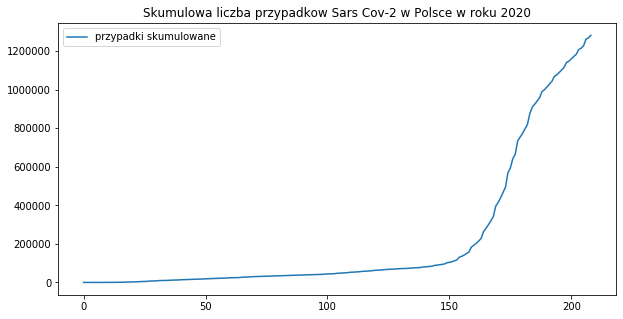

In [79]:

plt.figure(figsize = (10,5))
plt.title("Skumulowa liczba przypadkow Sars Cov-2 w Polsce w roku 2020")
plt.plot(ing_covid['covid_cum'], label = 'przypadki skumulowane')
plt.legend()

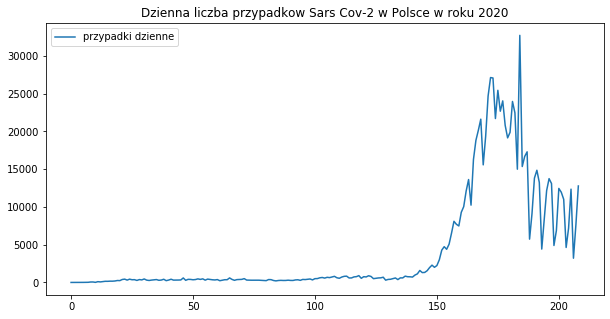

In [80]:
plt.figure(figsize = (10,5))
plt.title("Dzienna liczba przypadkow Sars Cov-2 w Polsce w roku 2020")
plt.plot(ing_covid['covid_day'], label = 'przypadki dzienne')
plt.legend()

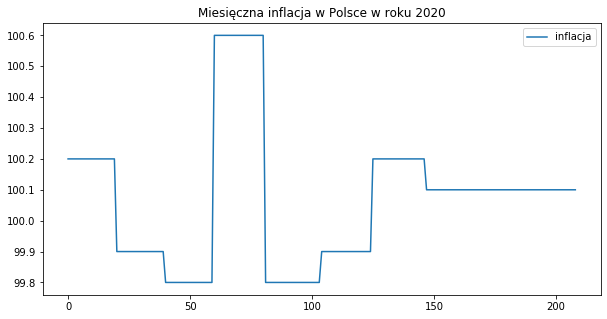

In [81]:
plt.figure(figsize = (10,5))
plt.title("Miesięczna inflacja w Polsce w roku 2020")
plt.plot(ing_covid['inflacja'], label = 'inflacja')
plt.legend()

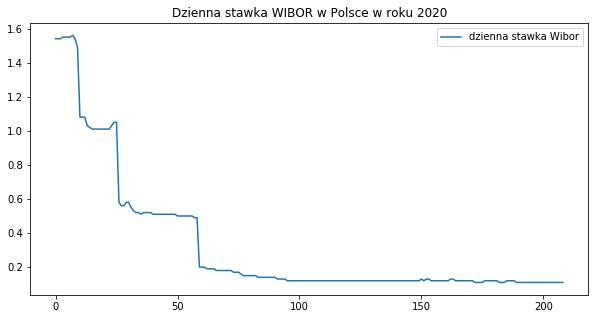

In [82]:
plt.figure(figsize = (10,5))
plt.title("Dzienna stawka WIBOR w Polsce w roku 2020")
plt.plot(ing_covid['Wibor_d'], label = 'dzienna stawka Wibor')
plt.legend()

In [268]:
covid.corr()

covid_cum  covid_day  inflacja   Wibor_d
covid_cum   1.000000   0.673298  0.078130 -0.312077
covid_day   0.673298   1.000000  0.076264 -0.293857
inflacja    0.078130   0.076264  1.000000 -0.014852
Wibor_d    -0.312077  -0.293857 -0.014852  1.000000

Sieć neuronowa

In [83]:
def regresja_wielomianowa(df, df_test, nazwa): 
    
    import statsmodels.api as sm
    from sklearn.metrics import r2_score

    
    x_train = df.drop('close',axis=1)
    x_train = x_train.set_index('date')
    
    x_test = df_test.drop('close', axis=1)
    x_test = x_test.set_index('date')
    
    df = df.set_index('date')
    y_train = df[['close']]
    
    df_test = df_test.set_index('date')
    y_test = df_test[['close']]

    
    X = x_train[['vol','covid_cum', 'covid_day', 'inflacja', 'Wibor_d']]
    y = y_train
    
    model = sm.OLS(y, X)
    predictor = model.fit()
    print(predictor.summary())
    
    predictor = model.fit()
    y_prediction =  predictor.predict(x_test)
    

    
  # Błędy prognozy
    mae = mean_absolute_error(y_test['close'], y_prediction)
    print(f'MAE dla prognozy akcji {nazwa}: {mae}')
    mse = mean_squared_error(y_test['close'], y_prediction)
    print(f'MSE dla prognozy akcji {nazwa}: {mse}')
    rmse = np.sqrt(mse)
    print(f'RMSE dla pognozy akcji {nazwa}: {rmse}')
    MAPE = mape(y_test['close'], y_prediction)
    print(f'MAPE dla pognozy akcji {nazwa}: {MAPE}')
    
    prediction =  pd.DataFrame(y_prediction, columns = ["close"], index = df_test.index)

    wspolczynniki_Theila(df_test['close'], prediction)
    


    
  # Wykres
    
    plt.figure(figsize = (15,10))
    plt.title(f"Model KMNK dla {nazwa}")
    plt.plot(y_train['close'], label = 'dane treningowe')
    plt.plot(y_test['close'], color = 'blue', label = 'dane testowe')
    plt.plot(prediction, color = 'green', label = 'pognozy')
    plt.legend()
    
    return plt.show()
    
    
    

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              6513.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                   7.86e-223
Time:                        01:00:40   Log-Likelihood:                         -802.68
No. Observations:                 209   AIC:                                      1615.
Df Residuals:                     204   BIC:                                      1632.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

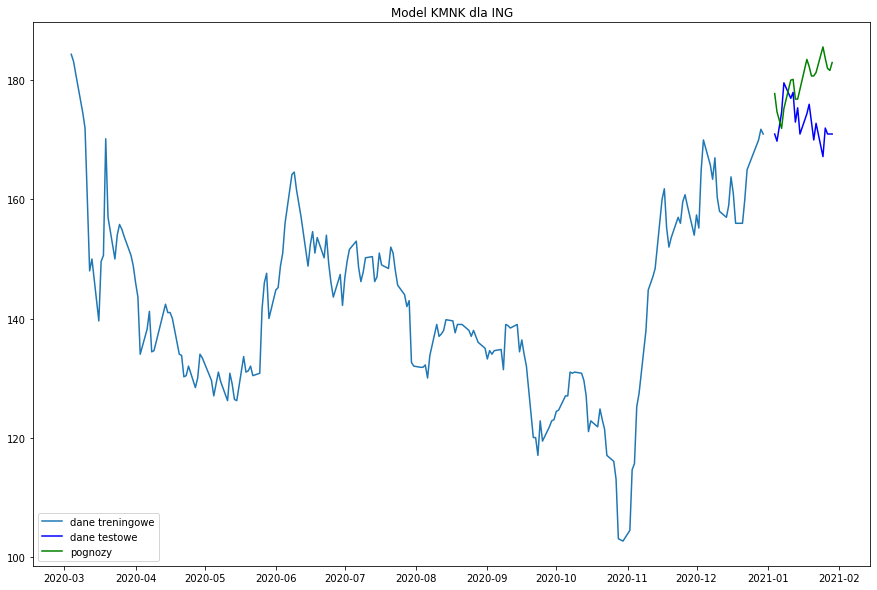

In [84]:
regresja_wielomianowa(ing_covid, ing_covid_t, "ING")

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              4276.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                   2.47e-204
Time:                        01:00:41   Log-Likelihood:                         -280.17
No. Observations:                 209   AIC:                                      570.3
Df Residuals:                     204   BIC:                                      587.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

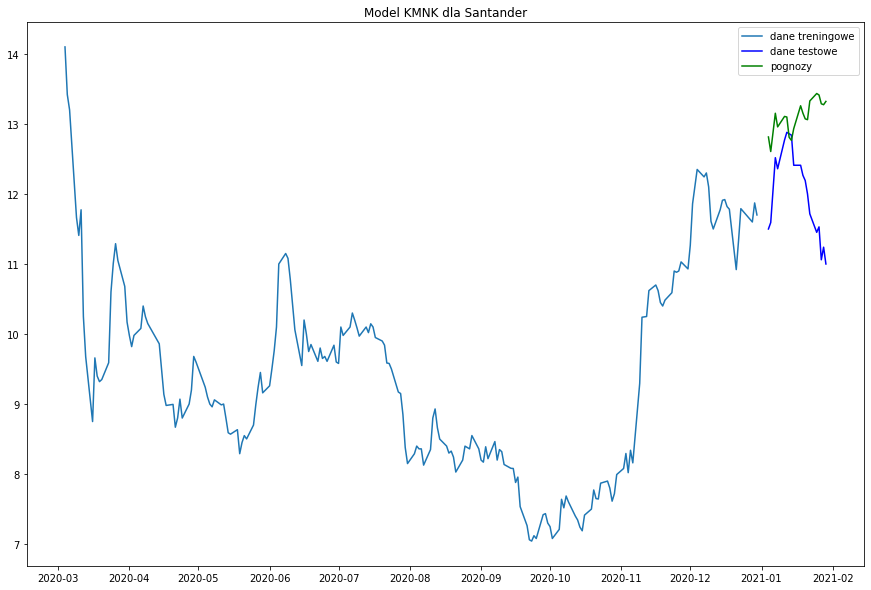

In [85]:
regresja_wielomianowa(santander_covid, santander_covid_t, "Santander")

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              4864.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                   5.40e-210
Time:                        01:00:41   Log-Likelihood:                         -633.67
No. Observations:                 209   AIC:                                      1277.
Df Residuals:                     204   BIC:                                      1294.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

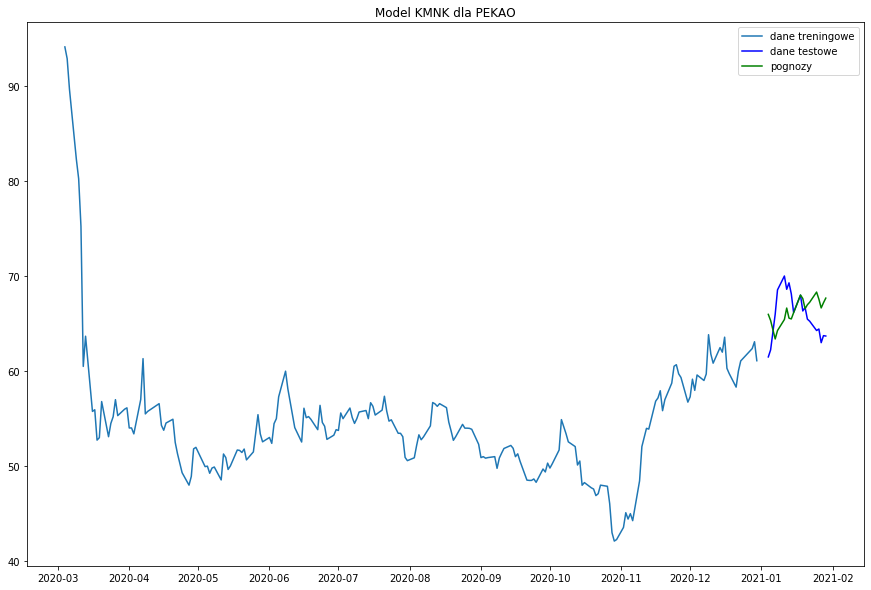

In [86]:
regresja_wielomianowa(pekao_covid, pekao_covid_t, "PEKAO")

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              9014.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                   3.80e-237
Time:                        01:00:41   Log-Likelihood:                         -390.03
No. Observations:                 209   AIC:                                      790.1
Df Residuals:                     204   BIC:                                      806.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

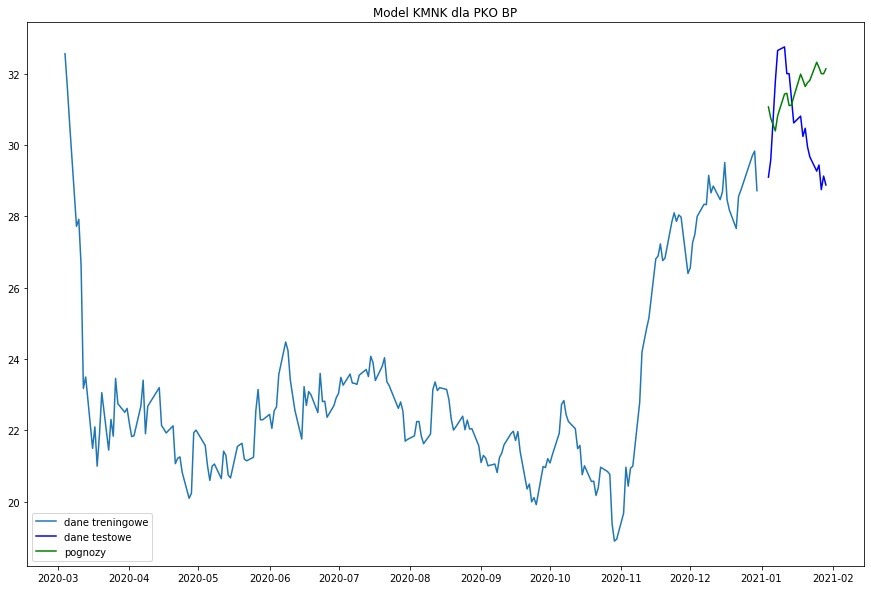

In [87]:
regresja_wielomianowa(pkobp_covid, pkobp_covid_t, "PKO BP")

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              2972.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                   2.11e-188
Time:                        01:00:41   Log-Likelihood:                         -953.27
No. Observations:                 209   AIC:                                      1917.
Df Residuals:                     204   BIC:                                      1933.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

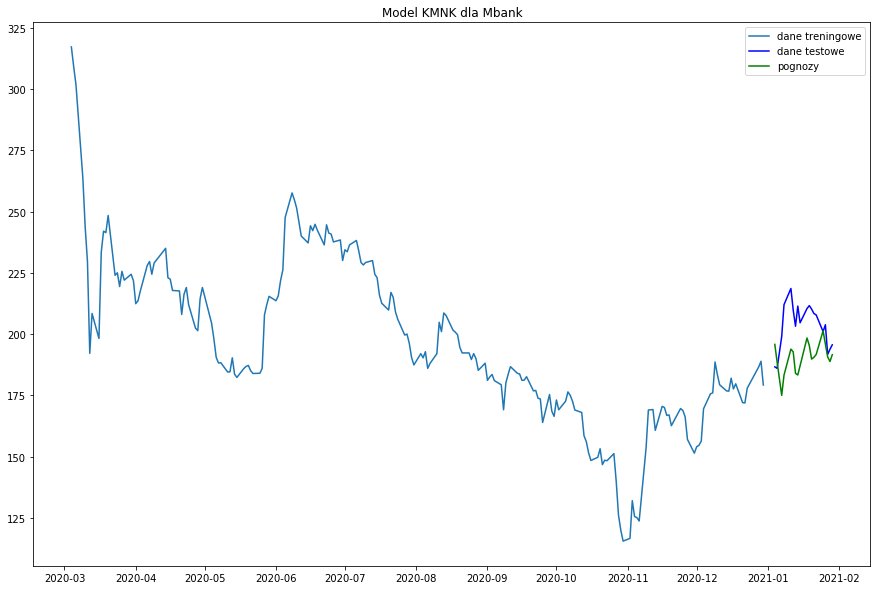

In [88]:
regresja_wielomianowa(mbank_covid, mbank_covid_t, "Mbank")

ARIMA

In [166]:
def zbior_uczacy(df):
    
    """
    Funkcja tworząca zbior uczący dla algorytmow. 
    zbiorem tesotywm jest cały rok 2021. 
    """
  
    df['date']=pd.to_datetime(df.date)
    df = df[['date', 'close',]]
    start_date = '2020-01-01'
    end_date = '2021-01-01'
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    
    return df
    

In [167]:
def zbior_testowy(df):
    
    """
    Funkcja tworząca zbior testowy dla algorytmow. 
    zbiorem tesotywm są ceny zamknięcia za styczen 2021.
    """
    
    df['date']=pd.to_datetime(df.date)
    df = df[['date', 'close', ]]
    start_date = '2021-01-01'
    end_date = '2021-01-31'
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    
    return df

In [261]:
from sklearn import preprocessing
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import ConvLSTM2D


def rekurencyjna_neuronowa(df, nazwa):
    
    
    train_data = zbior_uczacy(df)
    test_data = zbior_testowy(df)
    
    frames = [train_data, test_data]
    data= pd.concat(frames)

#creating train and test sets
    
    data = data.drop(["date"], axis=1)
    dataset = data.values
    
    train = dataset[0:len(train_data),:]
    valid = dataset[len(train_data):,:]

#converting dataset into x_train and y_train
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(8,len(train)):
        x_train.append(scaled_data[i-8:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=8, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=8))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    #predicting 246 values, using past 60 from the train data
    inputs = data[len(data) - len(valid) - 8:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(8,inputs.shape[0]):
        X_test.append(inputs[i-8:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

#for plotting
    train = data[:len(train)]
    valid = data[len(train):]
    valid['Predictions'] = closing_price
    plt.plot(train['close'])
    plt.plot(valid[['close','Predictions']])

    # bledy expost 
    predictions = closing_price
    predictions_df = pd.DataFrame(index=test_data.index, data=predictions)
    
    df_test = test_data
    # bledy expost 
    
    mae = mean_absolute_error(df_test['close'], predictions_df)
    print(f'MAE dla prognozy akcji {nazwa}: {mae}')
    mse = mean_squared_error(df_test['close'], predictions_df)
    print(f'MSE dla prognozy akcji {nazwa}: {mse}')
    rmse = np.sqrt(mse)
    print(f'RMSE dla pognozy akcji {nazwa}: {rmse}')
    MAPE = mape(df_test['close'], predictions_df)
    print(f'MAPE dla pognozy akcji {nazwa}: {MAPE}')
    
    wspolczynniki_Theila(df_test['close'], predictions_df)
    

    
# Visualisation
    plt.figure(figsize = (15,10))
    plt.title(f"Model sieci neuronowej long short-memory dla {nazwa}")
    plt.plot(train_data['close'], label = 'dane treningowe')
    plt.plot(df_test['close'], color = 'blue', label = 'dane testowe')
    plt.plot(predictions_df, color = 'green', label = 'pognozy')
    plt.legend()
    
    return plt.show()

244/244 - 3s - loss: 0.0284


C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MAE dla prognozy akcji PKOBP: 1.3092055792557566
MSE dla prognozy akcji PKOBP: 2.5192717328678036
RMSE dla pognozy akcji PKOBP: 1.587221387478068
MAPE dla pognozy akcji PKOBP: 4.047063108204036
Współczynnik theila wynosi: 0.0027683435396447065
Współczynnik obciazonosci prognozy wynosi: 0     0.032434
1     0.032434
2     0.032434
3     0.032434
4     0.032434
5     0.032434
6     0.032434
7     0.032434
8     0.032434
9     0.032434
10    0.032434
11    0.032434
12    0.032434
13    0.032434
14    0.032434
15    0.032434
16    0.032434
17    0.032434
18    0.032434
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 1.7086056711007915


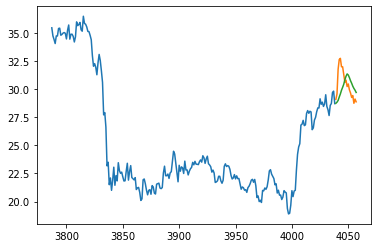

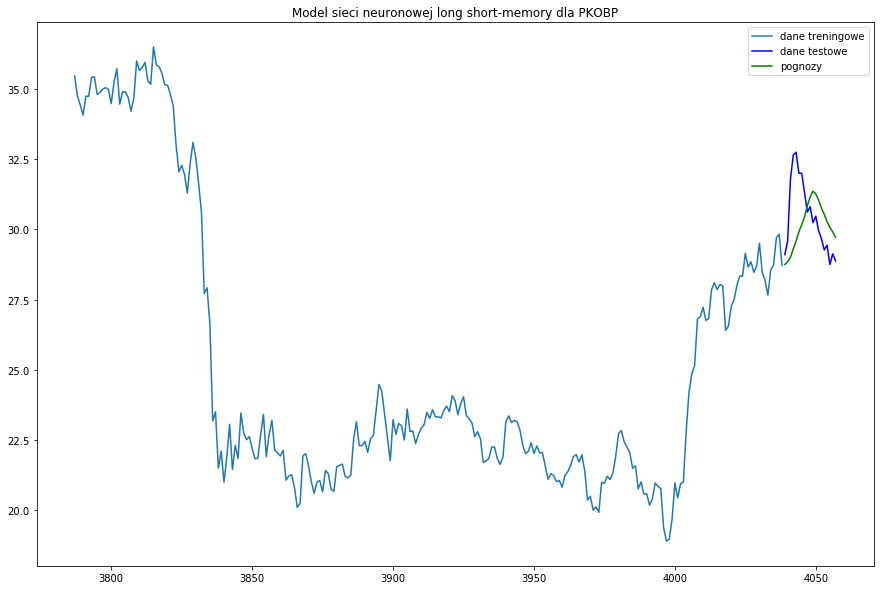

In [262]:
rekurencyjna_neuronowa(pkobp, "PKOBP")

244/244 - 3s - loss: 0.0345
MAE dla prognozy akcji ING: 6.574737870065792
MSE dla prognozy akcji ING: 60.01676791080617
RMSE dla pognozy akcji ING: 7.7470489807930205
MAPE dla pognozy akcji ING: 3.777343911948368
Współczynnik theila wynosi: 0.0021635106629716715
Współczynnik obciazonosci prognozy wynosi: 0     0.7068
1     0.7068
2     0.7068
3     0.7068
4     0.7068
5     0.7068
6     0.7068
7     0.7068
8     0.7068
9     0.7068
10    0.7068
11    0.7068
12    0.7068
13    0.7068
14    0.7068
15    0.7068
16    0.7068
17    0.7068
18    0.7068
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 0.00599259108836665


C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



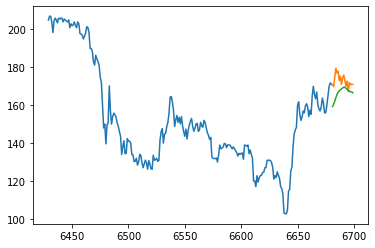

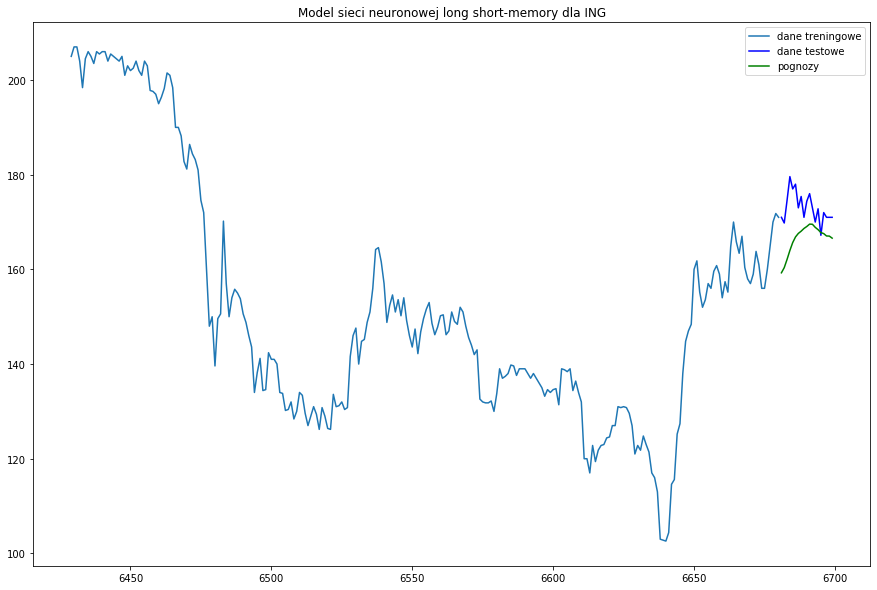

In [263]:
rekurencyjna_neuronowa(ing, "ING")

242/242 - 3s - loss: 0.0204
MAE dla prognozy akcji Santander: 0.6416330670808491
MSE dla prognozy akcji Santander: 0.529165300685652
RMSE dla pognozy akcji Santander: 0.727437489194537
MAPE dla pognozy akcji Santander: 5.08942580775442
Współczynnik theila wynosi: 0.0036255063418171238
Współczynnik obciazonosci prognozy wynosi: 0     0.003538
1     0.003538
2     0.003538
3     0.003538
4     0.003538
5     0.003538
6     0.003538
7     0.003538
8     0.003538
9     0.003538
10    0.003538
11    0.003538
12    0.003538
13    0.003538
14    0.003538
15    0.003538
16    0.003538
17    0.003538
18    0.003538
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 1.6257765341104005


C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



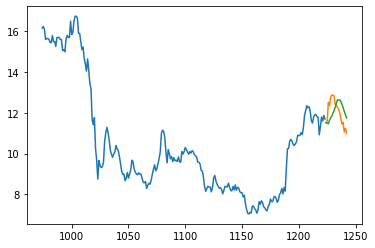

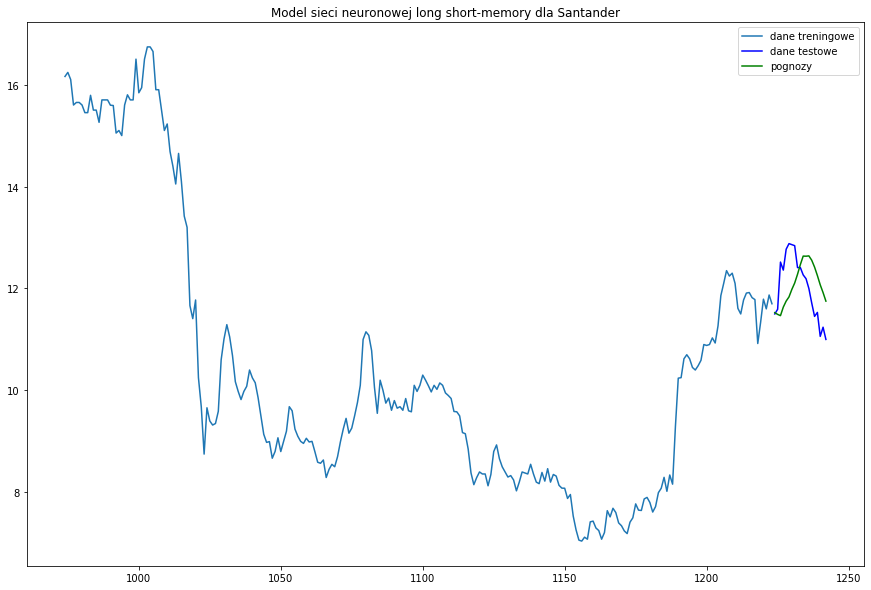

In [264]:
rekurencyjna_neuronowa(santander, "Santander")

244/244 - 3s - loss: 0.0287
MAE dla prognozy akcji Pekao: 2.748430007131476
MSE dla prognozy akcji Pekao: 11.429714634583581
RMSE dla pognozy akcji Pekao: 3.3807860971353363
MAPE dla pognozy akcji Pekao: 4.255672403728697
Współczynnik theila wynosi: 0.002699951122939542
Współczynnik obciazonosci prognozy wynosi: 0     0.062755
1     0.062755
2     0.062755
3     0.062755
4     0.062755
5     0.062755
6     0.062755
7     0.062755
8     0.062755
9     0.062755
10    0.062755
11    0.062755
12    0.062755
13    0.062755
14    0.062755
15    0.062755
16    0.062755
17    0.062755
18    0.062755
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 0.004476399231184412


C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



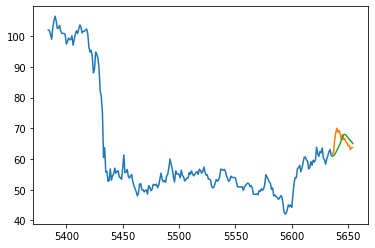

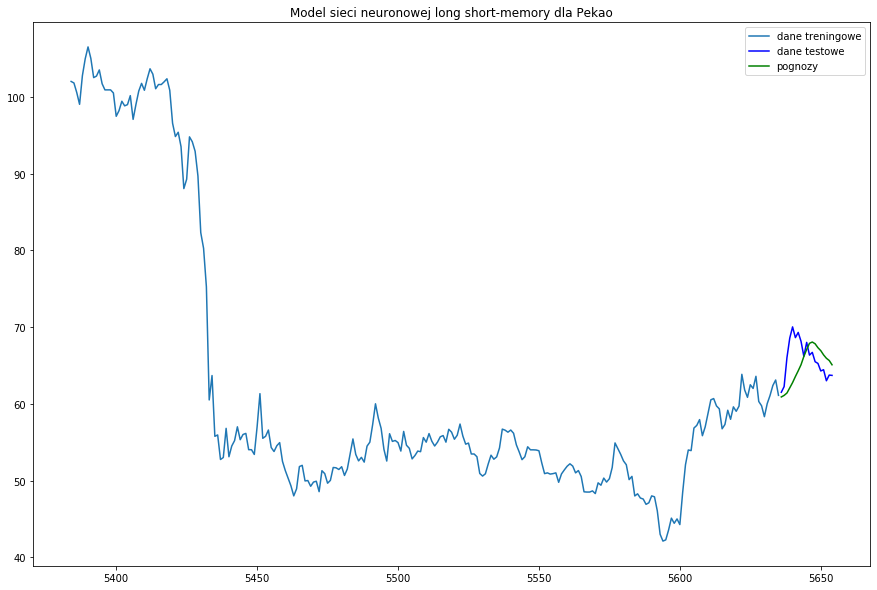

In [265]:
rekurencyjna_neuronowa(pekao, "Pekao")

244/244 - 3s - loss: 0.0186
MAE dla prognozy akcji Mbank: 10.590525416324013
MSE dla prognozy akcji Mbank: 180.91180163146632
RMSE dla pognozy akcji Mbank: 13.450345781111588
MAPE dla pognozy akcji Mbank: 5.865379894344505
Współczynnik theila wynosi: 0.004739406169950849
Współczynnik obciazonosci prognozy wynosi: 0     0.376355
1     0.376355
2     0.376355
3     0.376355
4     0.376355
5     0.376355
6     0.376355
7     0.376355
8     0.376355
9     0.376355
10    0.376355
11    0.376355
12    0.376355
13    0.376355
14    0.376355
15    0.376355
16    0.376355
17    0.376355
18    0.376355
Name: (sr_f_i - sr_y_i)^2, dtype: float64
Współczynnik elastycznoscici prognozy wynosi: 0.031676081080368707


C:\Users\patry\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



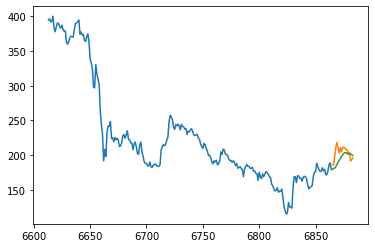

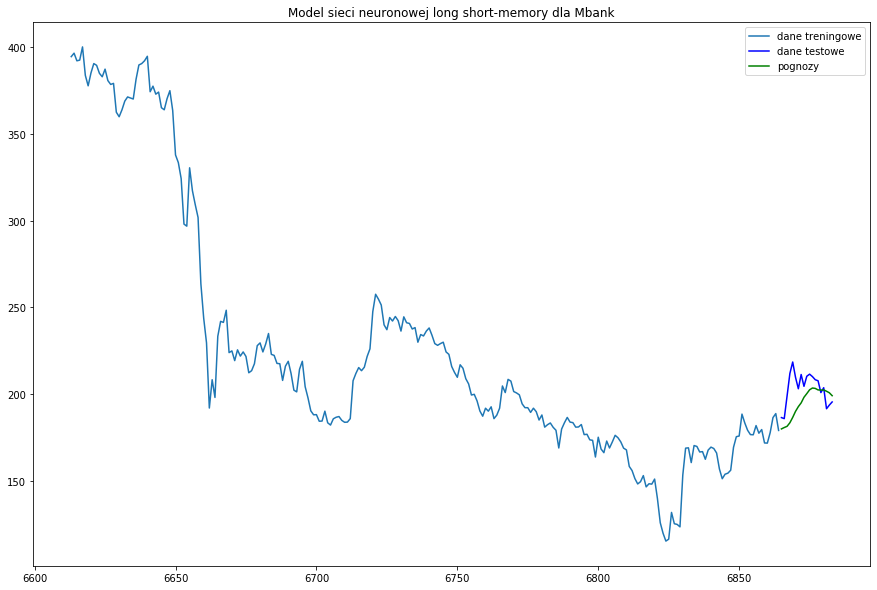

In [266]:
rekurencyjna_neuronowa(mbank, "Mbank")